In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import catboost as cb

In [2]:
df_all = pd.read_csv(r"E:\Ph.D\Machine Learning\Paper2_CO2\02Mypaper_Ndoped.csv")

In [3]:
df_all.describe()

,SA,TPV,MPV,C,H,N,O,T,P,CO2,H/C,N/C,O/C,MSPV,MPV/TPV,MSPV/TPV,N6,N5,NQ,NX
count,300.000000,300.000000,176.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,65.000000,65.000000,300.000000,300.000000
mean,1557.995333,0.807582,0.560795,77.102033,1.813733,3.960333,17.031333,19.433333,0.923500,3.585999,0.025151,0.055157,0.247465,0.227035,0.762537,0.237463,0.975455,1.685632,0.132066,0.030558
std,681.077979,0.443633,0.323763,11.111816,1.429351,2.815380,9.786280,10.442335,0.243661,1.367410,0.020202,0.044424,0.195692,0.254048,0.318378,0.318378,0.945632,1.202715,0.463716,0.149805
min,32.000000,0.020000,0.040000,43.500000,0.000000,0.000000,1.380000,0.000000,0.150000,0.360000,0.000000,0.000000,0.014963,-0.086000,0.036036,-4.300000,0.038000,0.349600,0.000000,0.000000
25%,1030.750000,0.477500,0.310000,70.320000,0.542500,1.997500,10.000000,25.000000,1.000000,2.697500,0.006025,0.023428,0.117514,0.070000,0.675861,0.147195,0.435600,0.746600,0.000000,0.000000
50%,1467.550000,0.680000,0.480000,79.105000,1.780000,3.150000,15.335000,25.000000,1.000000,3.605000,0.026204,0.042452,0.191227,0.156405,0.776985,0.223015,0.680000,1.215636,0.000000,0.000000
75%,1988.000000,1.032500,0.762500,86.305000,2.580000,5.050000,22.102500,25.000000,1.000000,4.335000,0.037046,0.070673,0.307763,0.300000,0.852805,0.324139,1.267270,2.318760,0.000000,0.000000
max,3247.000000,3.090000,1.320000,94.330000,6.010000,13.050000,50.100000,30.000000,1.000000,8.068182,0.071783,0.201513,1.151724,1.913800,5.300000,0.963964,6.160000,5.369580,3.861200,1.547620


In [4]:
df_all.head()

,SA,TPV,MPV,C,H,N,O,T,P,CO2,H/C,N/C,O/C,MSPV,MPV/TPV,MSPV/TPV,N6,N5,NQ,NX
0,660.0,0.28,0.24,83.48,0.01,3.53,12.98,25,1.0,2.94,0.000120,0.042286,0.155486,0.04,0.857143,0.142857,1.267270,1.513664,0.176853,0.571860
1,1076.0,0.44,0.38,84.57,2.94,3.03,9.46,25,1.0,4.11,0.034764,0.035828,0.111860,0.06,0.863636,0.136364,1.286235,0.576306,1.167459,0.038178
2,1268.0,0.55,0.50,90.49,0.00,2.12,7.39,25,1.0,3.64,0.000000,0.023428,0.081666,0.05,0.909091,0.090909,0.634516,1.029896,0.163876,0.197160
3,1480.0,0.71,0.48,89.42,1.46,2.08,7.04,25,1.0,3.31,0.016327,0.023261,0.078730,0.23,0.676056,0.323944,0.496704,1.059344,0.235040,0.288912
4,1161.0,0.38,0.35,88.44,0.01,3.02,8.53,25,1.0,3.69,0.000113,0.034147,0.096450,0.03,0.921053,0.078947,0.835936,1.169344,0.894826,0.119592


<Axes: title={'center': 'Pearson Correlation of Features'}>

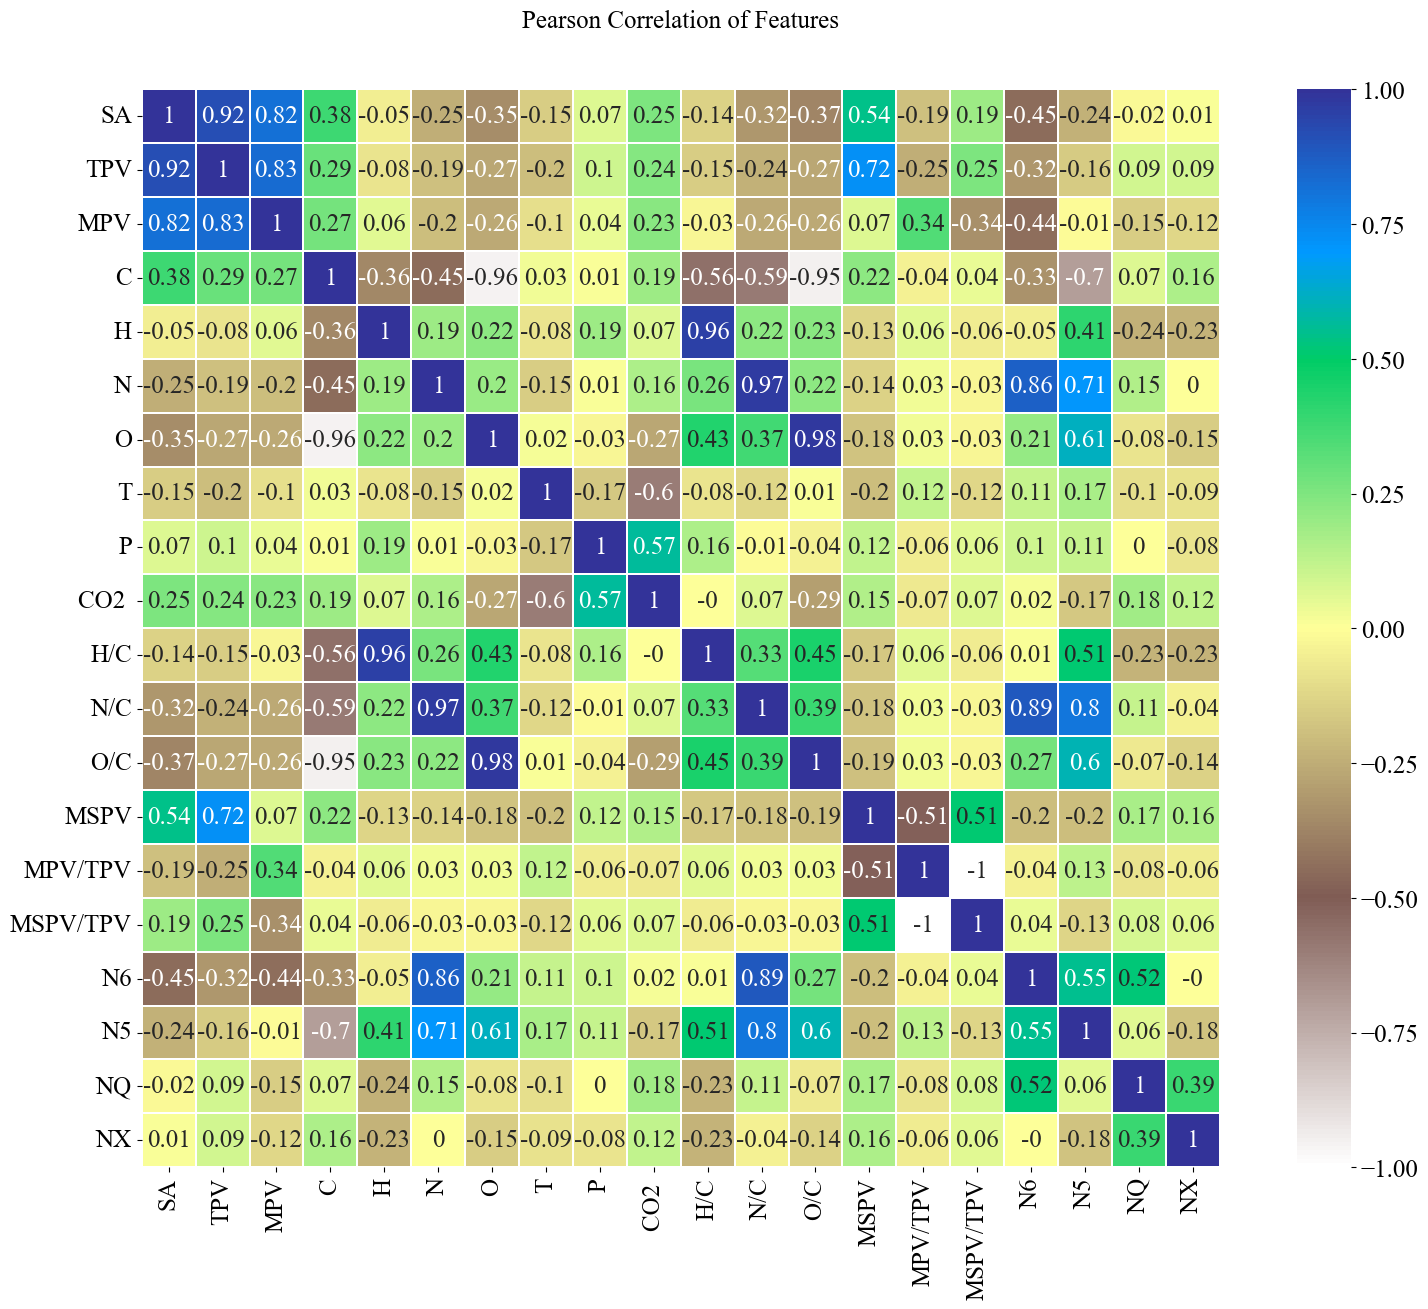

In [5]:
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
label_size = 18
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size
colormap = plt.cm.terrain_r
plt.figure(figsize=(20,14))
plt.title('Pearson Correlation of Features', y=1.05, size=18)
sns.heatmap(df_all.corr().round(decimals=2),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"fontsize":18})

In [6]:
def feature_impute(df_all, target):
    '''
    Evaluates different models to predict and impute null values.
    Models used were LR, RF, XGB, LGBM. 
    RF was superior (based on R2) so it was used.
    Args:
        df_all: DataFrame
        target: feature name to be imputed
    
    Returns:
        DataFrame with imputed data
    '''
    df_mv = df_all[["N/C", target]].copy()
    df_mv = df_mv.dropna()

    x = np.array(df_mv["N/C"]).reshape(-1,1)
    y = np.array(df_mv[target]).reshape(-1,1)

    x_train, x_test , y_train , y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

    print("LR:")
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    pred = lr.predict(x_test)
    scores = cross_val_score(lr, x_train, y_train , cv=3, scoring='r2')
    score = np.mean(scores)
    print("Train R2: %.3f (+/- %.3f) \n" %(score, scores.std()))
    print("Test R2: %.3f\n" %(r2_score(y_test, pred)))

    print("RF: ")
    rf = RandomForestRegressor(random_state =42)
    rf.fit(x_train, y_train)
    pred = rf.predict(x_test)
    scores = cross_val_score(rf, x_train, y_train , cv=3, scoring='r2')
    score = np.mean(scores)
    print("Train R2: %.3f (+/- %.3f) \n" %(score, scores.std()))
    print("Test R2: %.3f\n" %(r2_score(y_test, pred)))

    print("LGB: ")
    lg = LGBMRegressor(seed = 42)
    lg.fit(x_train, y_train)
    pred = lg.predict(x_test)
    scores = cross_val_score(lg, x_train, y_train , cv=3, scoring='r2')
    score = np.mean(scores)
    print("Train R2: %.3f (+/- %.3f) \n" %(score, scores.std()))
    print("Test R2: %.3f\n" %(r2_score(y_test, pred)))

    print("XGB: ")
    xg = XGBRegressor()
    xg.fit(x_train, y_train)
    pred = xg.predict(x_test)
    scores = cross_val_score(xg, x_train, y_train , cv=3, scoring='r2')
    score = np.mean(scores)
    print("Train R2: %.3f (+/- %.3f) \n" %(score, scores.std()))
    print("Test R2: %.3f\n" %(r2_score(y_test, pred)))
    

    
    # As RF is best:
    name = target + "_imputed"
    p = rf.predict(np.array(df_all["N/C"]).reshape(-1,1))
    df_all[name] = p
    return df_all

In [7]:
feature_impute(df_all, "N6")
feature_impute(df_all, "N5")

LR:
Train R2: 0.665 (+/- 0.197) 

Test R2: 0.715

RF: 


C:\Users\Administrator\AppData\Local\Temp\ipykernel_13952\3281835066.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)
C:\Program Files\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Program Files\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Program Files\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array w

Train R2: 0.709 (+/- 0.091) 

Test R2: 0.855

LGB: 
Train R2: -0.196 (+/- 0.033) 

Test R2: 0.251

XGB: 
Train R2: 0.721 (+/- 0.083) 

Test R2: 0.905

LR:
Train R2: 0.498 (+/- 0.085) 

Test R2: 0.691

RF: 


C:\Users\Administrator\AppData\Local\Temp\ipykernel_13952\3281835066.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)
C:\Program Files\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Program Files\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


Train R2: 0.611 (+/- 0.278) 

Test R2: 0.734

LGB: 
Train R2: -0.152 (+/- 0.078) 

Test R2: 0.681

XGB: 
Train R2: 0.554 (+/- 0.294) 

Test R2: 0.694



C:\Program Files\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

,SA,TPV,MPV,C,H,N,O,T,P,CO2,...,O/C,MSPV,MPV/TPV,MSPV/TPV,N6,N5,NQ,NX,N6_imputed,N5_imputed
0,660.0,0.28,0.24,83.48,0.01,3.53,12.98,25,1.0,2.94,...,0.155486,0.04,0.857143,0.142857,1.267270,1.513664,0.176853,0.571860,1.257586,1.500491
1,1076.0,0.44,0.38,84.57,2.94,3.03,9.46,25,1.0,4.11,...,0.111860,0.06,0.863636,0.136364,1.286235,0.576306,1.167459,0.038178,1.265911,0.628509
2,1268.0,0.55,0.50,90.49,0.00,2.12,7.39,25,1.0,3.64,...,0.081666,0.05,0.909091,0.090909,0.634516,1.029896,0.163876,0.197160,0.594551,1.038436
3,1480.0,0.71,0.48,89.42,1.46,2.08,7.04,25,1.0,3.31,...,0.078730,0.23,0.676056,0.323944,0.496704,1.059344,0.235040,0.288912,0.499460,1.058755
4,1161.0,0.38,0.35,88.44,0.01,3.02,8.53,25,1.0,3.69,...,0.096450,0.03,0.921053,0.078947,0.835936,1.169344,0.894826,0.119592,0.830479,1.177599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2672.0,1.58,1.31,88.06,3.87,3.04,5.03,0,1.0,5.10,...,0.057120,0.27,0.829114,0.170886,NaN,NaN,0.000000,0.000000,0.834060,1.171740
296,2644.0,1.62,1.32,87.68,3.24,2.65,6.43,0,1.0,5.47,...,0.073335,0.30,0.814815,0.185185,NaN,NaN,0.000000,0.000000,0.561839,1.103445
297,2112.0,1.26,0.92,92.23,3.56,2.83,1.38,0,1.0,5.72,...,0.014963,0.34,0.730159,0.269841,NaN,NaN,0.000000,0.000000,0.561839,1.103445
298,2747.0,1.62,1.19,91.56,2.45,2.36,3.63,0,1.0,4.94,...,0.039646,0.43,0.734568,0.265432,NaN,NaN,0.000000,0.000000,0.407166,1.652055


In [10]:
df_all["N6"] = df_all["N6"].fillna(df_all["N6_imputed"])
df_all["N5"] = df_all["N5"].fillna(df_all["N5_imputed"])

In [11]:
# drop unrequired featues
df1 = df_all.drop(['N6_imputed','N5_imputed'], axis = 1)

In [12]:
#Processed dataset
df1.head()

,SA,TPV,MPV,C,H,N,O,T,P,CO2,H/C,N/C,O/C,MSPV,MPV/TPV,MSPV/TPV,N6,N5,NQ,NX
0,660.0,0.28,0.24,83.48,0.01,3.53,12.98,25,1.0,2.94,0.000120,0.042286,0.155486,0.04,0.857143,0.142857,1.267270,1.513664,0.176853,0.571860
1,1076.0,0.44,0.38,84.57,2.94,3.03,9.46,25,1.0,4.11,0.034764,0.035828,0.111860,0.06,0.863636,0.136364,1.286235,0.576306,1.167459,0.038178
2,1268.0,0.55,0.50,90.49,0.00,2.12,7.39,25,1.0,3.64,0.000000,0.023428,0.081666,0.05,0.909091,0.090909,0.634516,1.029896,0.163876,0.197160
3,1480.0,0.71,0.48,89.42,1.46,2.08,7.04,25,1.0,3.31,0.016327,0.023261,0.078730,0.23,0.676056,0.323944,0.496704,1.059344,0.235040,0.288912
4,1161.0,0.38,0.35,88.44,0.01,3.02,8.53,25,1.0,3.69,0.000113,0.034147,0.096450,0.03,0.921053,0.078947,0.835936,1.169344,0.894826,0.119592


In [13]:
df1.describe()

,SA,TPV,MPV,C,H,N,O,T,P,CO2,H/C,N/C,O/C,MSPV,MPV/TPV,MSPV/TPV,N6,N5,NQ,NX
count,300.000000,300.000000,176.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,1557.995333,0.807582,0.560795,77.102033,1.813733,3.960333,17.031333,19.433333,0.923500,3.585999,0.025151,0.055157,0.247465,0.227035,0.762537,0.237463,1.074443,2.020532,0.132066,0.030558
std,681.077979,0.443633,0.323763,11.111816,1.429351,2.815380,9.786280,10.442335,0.243661,1.367410,0.020202,0.044424,0.195692,0.254048,0.318378,0.318378,1.036294,1.279034,0.463716,0.149805
min,32.000000,0.020000,0.040000,43.500000,0.000000,0.000000,1.380000,0.000000,0.150000,0.360000,0.000000,0.000000,0.014963,-0.086000,0.036036,-4.300000,0.038000,0.349600,0.000000,0.000000
25%,1030.750000,0.477500,0.310000,70.320000,0.542500,1.997500,10.000000,25.000000,1.000000,2.697500,0.006025,0.023428,0.117514,0.070000,0.675861,0.147195,0.459051,1.020500,0.000000,0.000000
50%,1467.550000,0.680000,0.480000,79.105000,1.780000,3.150000,15.335000,25.000000,1.000000,3.605000,0.026204,0.042452,0.191227,0.156405,0.776985,0.223015,0.845259,1.648182,0.000000,0.000000
75%,1988.000000,1.032500,0.762500,86.305000,2.580000,5.050000,22.102500,25.000000,1.000000,4.335000,0.037046,0.070673,0.307763,0.300000,0.852805,0.324139,1.272852,2.941128,0.000000,0.000000
max,3247.000000,3.090000,1.320000,94.330000,6.010000,13.050000,50.100000,30.000000,1.000000,8.068182,0.071783,0.201513,1.151724,1.913800,5.300000,0.963964,6.160000,5.369580,3.861200,1.547620


In [14]:
def feature_impute(df1, target):
    '''
    Evaluates different models to predict and impute null values.
    Models used were LR, RF, XGB, LGBM. 
    RF was superior (based on R2) so it was used.
    Args:
        df_all: DataFrame
        target: feature name to be imputed
    
    Returns:
        DataFrame with imputed data
    '''
    df_mv = df1[["SA", target]].copy()
    df_mv = df_mv.dropna()

    x = np.array(df_mv["SA"]).reshape(-1,1)
    y = np.array(df_mv[target]).reshape(-1,1)

    x_train, x_test , y_train , y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

    print("LR:")
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    pred = lr.predict(x_test)
    scores = cross_val_score(lr, x_train, y_train , cv=3, scoring='r2')
    score = np.mean(scores)
    print("Train R2: %.3f (+/- %.3f) \n" %(score, scores.std()))
    print("Test R2: %.3f\n" %(r2_score(y_test, pred)))

    print("RF: ")
    rf = RandomForestRegressor(random_state =42)
    rf.fit(x_train, y_train)
    pred = rf.predict(x_test)
    scores = cross_val_score(rf, x_train, y_train , cv=3, scoring='r2')
    score = np.mean(scores)
    print("Train R2: %.3f (+/- %.3f) \n" %(score, scores.std()))
    print("Test R2: %.3f\n" %(r2_score(y_test, pred)))

    print("LGB: ")
    lg = LGBMRegressor(seed = 42)
    lg.fit(x_train, y_train)
    pred = lg.predict(x_test)
    scores = cross_val_score(lg, x_train, y_train , cv=3, scoring='r2')
    score = np.mean(scores)
    print("Train R2: %.3f (+/- %.3f) \n" %(score, scores.std()))
    print("Test R2: %.3f\n" %(r2_score(y_test, pred)))

    print("XGB: ")
    xg = XGBRegressor()
    xg.fit(x_train, y_train)
    pred = xg.predict(x_test)
    scores = cross_val_score(xg, x_train, y_train , cv=3, scoring='r2')
    score = np.mean(scores)
    print("Train R2: %.3f (+/- %.3f) \n" %(score, scores.std()))
    print("Test R2: %.3f\n" %(r2_score(y_test, pred)))
    

    
    # As RF is best:
    name = target + "_imputed"
    p = rf.predict(np.array(df_all["SA"]).reshape(-1,1))
    df1[name] = p
    return df1

In [15]:
feature_impute(df1, "MPV")

LR:
Train R2: 0.716 (+/- 0.028) 

Test R2: 0.519

RF: 


C:\Users\Administrator\AppData\Local\Temp\ipykernel_13952\3804306386.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)
C:\Program Files\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Program Files\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Program Files\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array w

Train R2: 0.769 (+/- 0.058) 

Test R2: 0.898

LGB: 
Train R2: 0.687 (+/- 0.112) 

Test R2: 0.617

XGB: 
Train R2: 0.779 (+/- 0.092) 

Test R2: 0.957



,SA,TPV,MPV,C,H,N,O,T,P,CO2,...,N/C,O/C,MSPV,MPV/TPV,MSPV/TPV,N6,N5,NQ,NX,MPV_imputed
0,660.0,0.28,0.24,83.48,0.01,3.53,12.98,25,1.0,2.94,...,0.042286,0.155486,0.04,0.857143,0.142857,1.267270,1.513664,0.176853,0.571860,0.262385
1,1076.0,0.44,0.38,84.57,2.94,3.03,9.46,25,1.0,4.11,...,0.035828,0.111860,0.06,0.863636,0.136364,1.286235,0.576306,1.167459,0.038178,0.386300
2,1268.0,0.55,0.50,90.49,0.00,2.12,7.39,25,1.0,3.64,...,0.023428,0.081666,0.05,0.909091,0.090909,0.634516,1.029896,0.163876,0.197160,0.467500
3,1480.0,0.71,0.48,89.42,1.46,2.08,7.04,25,1.0,3.31,...,0.023261,0.078730,0.23,0.676056,0.323944,0.496704,1.059344,0.235040,0.288912,0.473000
4,1161.0,0.38,0.35,88.44,0.01,3.02,8.53,25,1.0,3.69,...,0.034147,0.096450,0.03,0.921053,0.078947,0.835936,1.169344,0.894826,0.119592,0.373200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2672.0,1.58,1.31,88.06,3.87,3.04,5.03,0,1.0,5.10,...,0.034522,0.057120,0.27,0.829114,0.170886,0.834060,1.171740,0.000000,0.000000,1.298600
296,2644.0,1.62,1.32,87.68,3.24,2.65,6.43,0,1.0,5.47,...,0.030224,0.073335,0.30,0.814815,0.185185,0.561839,1.103445,0.000000,0.000000,1.292600
297,2112.0,1.26,0.92,92.23,3.56,2.83,1.38,0,1.0,5.72,...,0.030684,0.014963,0.34,0.730159,0.269841,0.561839,1.103445,0.000000,0.000000,0.877200
298,2747.0,1.62,1.19,91.56,2.45,2.36,3.63,0,1.0,4.94,...,0.025775,0.039646,0.43,0.734568,0.265432,0.407166,1.652055,0.000000,0.000000,1.186400


In [16]:
df1["MPV"] = df1["MPV"].fillna(df1["MPV_imputed"])

In [17]:
df = df1.drop(['MPV_imputed'], axis = 1)

In [18]:
#Processed dataset
df.describe()

,SA,TPV,MPV,C,H,N,O,T,P,CO2,H/C,N/C,O/C,MSPV,MPV/TPV,MSPV/TPV,N6,N5,NQ,NX
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,1557.995333,0.807582,0.581783,77.102033,1.813733,3.960333,17.031333,19.433333,0.923500,3.585999,0.025151,0.055157,0.247465,0.227035,0.762537,0.237463,1.074443,2.020532,0.132066,0.030558
std,681.077979,0.443633,0.313650,11.111816,1.429351,2.815380,9.786280,10.442335,0.243661,1.367410,0.020202,0.044424,0.195692,0.254048,0.318378,0.318378,1.036294,1.279034,0.463716,0.149805
min,32.000000,0.020000,0.040000,43.500000,0.000000,0.000000,1.380000,0.000000,0.150000,0.360000,0.000000,0.000000,0.014963,-0.086000,0.036036,-4.300000,0.038000,0.349600,0.000000,0.000000
25%,1030.750000,0.477500,0.361300,70.320000,0.542500,1.997500,10.000000,25.000000,1.000000,2.697500,0.006025,0.023428,0.117514,0.070000,0.675861,0.147195,0.459051,1.020500,0.000000,0.000000
50%,1467.550000,0.680000,0.480000,79.105000,1.780000,3.150000,15.335000,25.000000,1.000000,3.605000,0.026204,0.042452,0.191227,0.156405,0.776985,0.223015,0.845259,1.648182,0.000000,0.000000
75%,1988.000000,1.032500,0.772500,86.305000,2.580000,5.050000,22.102500,25.000000,1.000000,4.335000,0.037046,0.070673,0.307763,0.300000,0.852805,0.324139,1.272852,2.941128,0.000000,0.000000
max,3247.000000,3.090000,1.320000,94.330000,6.010000,13.050000,50.100000,30.000000,1.000000,8.068182,0.071783,0.201513,1.151724,1.913800,5.300000,0.963964,6.160000,5.369580,3.861200,1.547620


<Axes: title={'center': 'Pearson Correlation of Features'}>

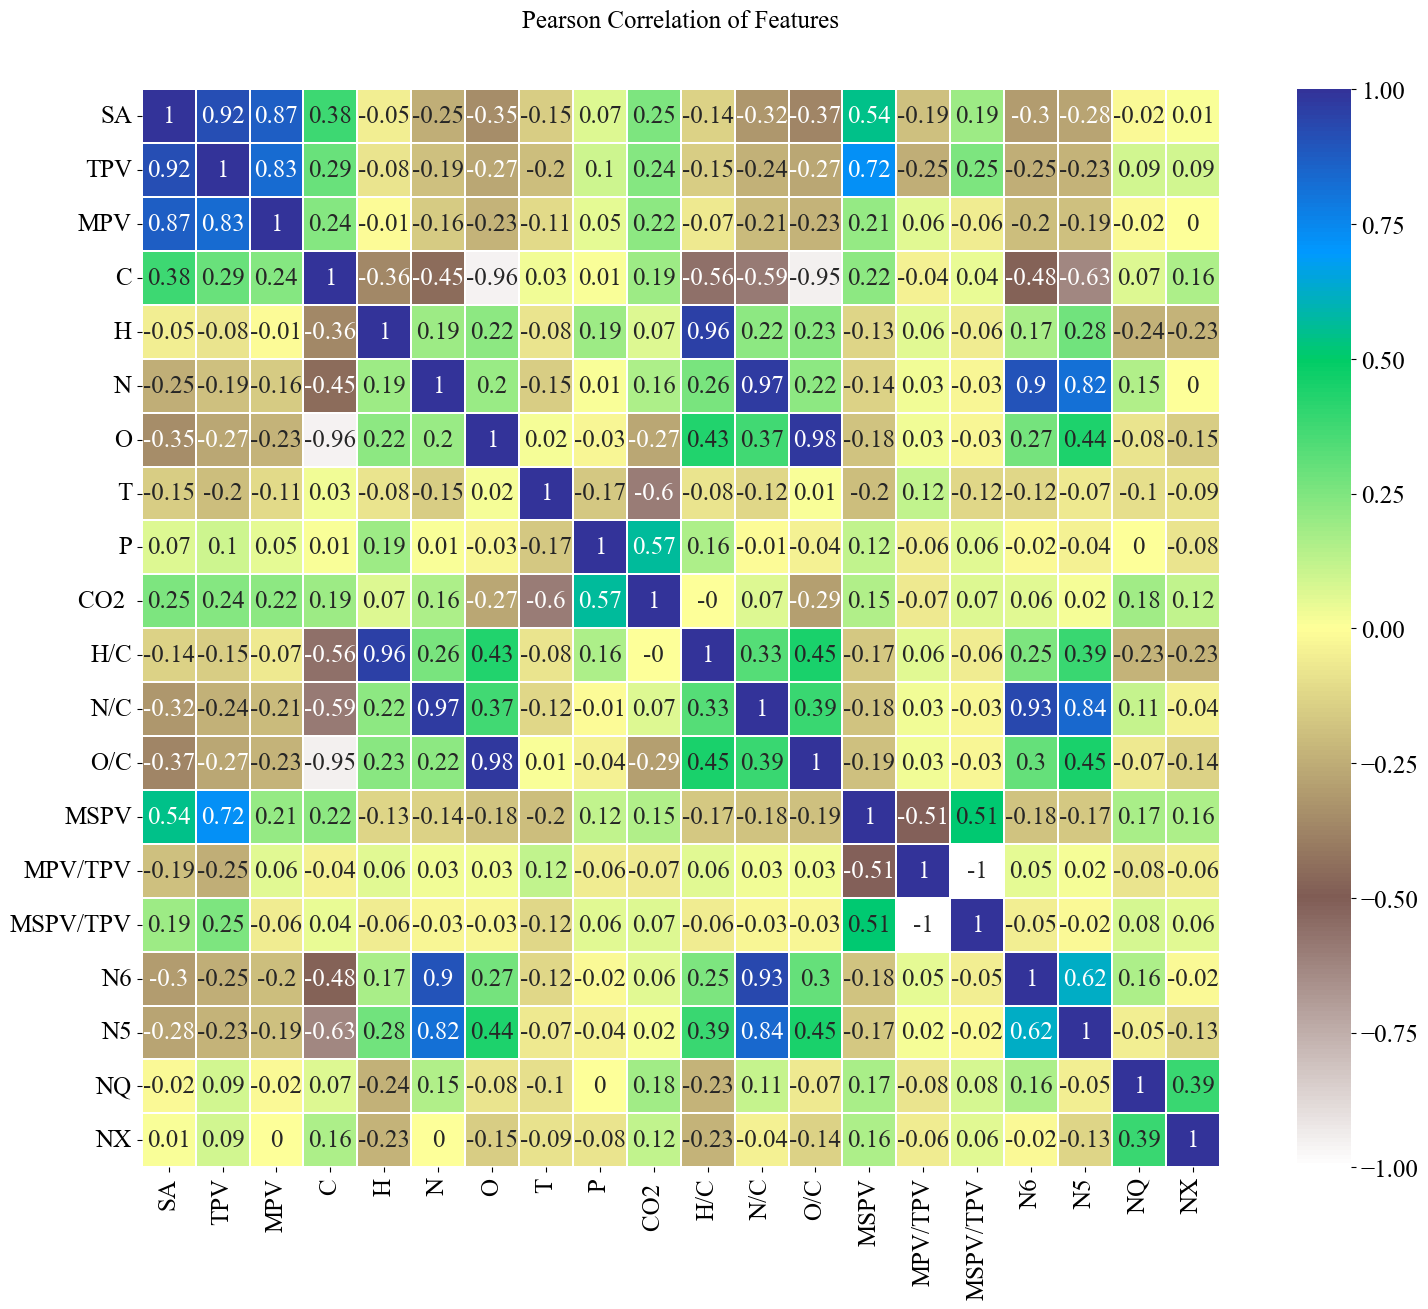

In [25]:
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
label_size = 18
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size
colormap = plt.cm.terrain_r
plt.figure(figsize=(20,14))
plt.title('Pearson Correlation of Features', y=1.05, size=18)
sns.heatmap(df.corr().round(decimals=2),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"fontsize":18})

In [26]:
#Defining the input features and target variable 

x = df.drop("CO2 ",axis=1)
y = df["CO2 "]

#spliting the dataset into 85:15 ratio

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [27]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(x_train)
x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)
x_std = sc.transform(x)

In [28]:
pd.DataFrame(x_train_std, columns=x_train.columns)

,SA,TPV,MPV,C,H,N,O,T,P,H/C,N/C,O/C,MSPV,MPV/TPV,MSPV/TPV,N6,N5,NQ,NX
0,0.353878,0.531056,0.367090,0.326218,-0.709798,-1.050226,0.061582,0.564132,-3.175997,-0.751062,-0.966848,-0.143396,0.458781,-0.280556,0.280556,-0.819609,-0.889340,-0.291476,-0.194635
1,-0.334348,-0.083087,-0.147206,-0.719060,-0.275170,0.055239,0.858183,0.564132,0.314862,-0.231289,0.098503,0.619027,0.031734,-0.204487,0.204487,-0.220267,0.339999,-0.291476,-0.194635
2,2.009501,1.236183,2.038551,0.663852,-1.254808,0.569244,-1.002668,0.564132,0.314862,-1.228316,0.251309,-0.827855,-0.356491,0.402940,-0.402940,-0.164740,0.391592,-0.291476,-0.194635
3,0.185181,0.167119,-0.082919,0.834982,-1.254808,-0.240491,-0.709629,0.564132,0.314862,-1.228316,-0.382685,-0.666397,0.381136,-0.391667,0.391667,0.049337,-0.437630,1.169577,-0.194635
4,0.082171,0.030643,0.045655,-0.103918,-1.254808,0.674862,0.044656,0.564132,0.314862,-1.228316,0.503185,-0.085175,-0.007089,-0.113755,0.113755,0.327895,0.578905,-0.291476,-0.194635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,-0.220887,-0.378786,-0.950793,0.086637,0.525098,0.139733,-0.211357,-1.763596,0.314862,0.381829,0.018314,-0.281651,0.497604,-0.934743,0.934743,-0.220267,0.339999,-0.291476,-0.194635
251,0.853999,1.145199,1.138534,-1.196373,-0.082002,0.558683,1.223160,0.564132,0.314862,0.060812,0.707800,1.056992,0.575249,-0.145707,0.145707,0.200505,1.784997,-0.291476,-0.194635
252,-1.080796,-0.992929,-0.886506,0.784105,-1.254808,-0.335546,-0.614418,0.564132,0.314862,-1.228316,-0.448271,-0.606475,-0.628249,0.161841,-0.161841,-0.176628,-0.625441,1.568486,-0.194635
253,0.080678,-0.356040,-0.082919,0.747104,-1.254808,-0.522138,-0.494875,0.564132,-3.175997,-1.228316,-0.584787,-0.532702,-0.511781,0.258838,-0.258838,-0.539278,-0.689684,-0.291476,-0.194635


In [29]:
x_train_std_n = pd.DataFrame(x_train_std, columns=x_train.columns)

In [30]:
x_train_std_n

,SA,TPV,MPV,C,H,N,O,T,P,H/C,N/C,O/C,MSPV,MPV/TPV,MSPV/TPV,N6,N5,NQ,NX
0,0.353878,0.531056,0.367090,0.326218,-0.709798,-1.050226,0.061582,0.564132,-3.175997,-0.751062,-0.966848,-0.143396,0.458781,-0.280556,0.280556,-0.819609,-0.889340,-0.291476,-0.194635
1,-0.334348,-0.083087,-0.147206,-0.719060,-0.275170,0.055239,0.858183,0.564132,0.314862,-0.231289,0.098503,0.619027,0.031734,-0.204487,0.204487,-0.220267,0.339999,-0.291476,-0.194635
2,2.009501,1.236183,2.038551,0.663852,-1.254808,0.569244,-1.002668,0.564132,0.314862,-1.228316,0.251309,-0.827855,-0.356491,0.402940,-0.402940,-0.164740,0.391592,-0.291476,-0.194635
3,0.185181,0.167119,-0.082919,0.834982,-1.254808,-0.240491,-0.709629,0.564132,0.314862,-1.228316,-0.382685,-0.666397,0.381136,-0.391667,0.391667,0.049337,-0.437630,1.169577,-0.194635
4,0.082171,0.030643,0.045655,-0.103918,-1.254808,0.674862,0.044656,0.564132,0.314862,-1.228316,0.503185,-0.085175,-0.007089,-0.113755,0.113755,0.327895,0.578905,-0.291476,-0.194635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,-0.220887,-0.378786,-0.950793,0.086637,0.525098,0.139733,-0.211357,-1.763596,0.314862,0.381829,0.018314,-0.281651,0.497604,-0.934743,0.934743,-0.220267,0.339999,-0.291476,-0.194635
251,0.853999,1.145199,1.138534,-1.196373,-0.082002,0.558683,1.223160,0.564132,0.314862,0.060812,0.707800,1.056992,0.575249,-0.145707,0.145707,0.200505,1.784997,-0.291476,-0.194635
252,-1.080796,-0.992929,-0.886506,0.784105,-1.254808,-0.335546,-0.614418,0.564132,0.314862,-1.228316,-0.448271,-0.606475,-0.628249,0.161841,-0.161841,-0.176628,-0.625441,1.568486,-0.194635
253,0.080678,-0.356040,-0.082919,0.747104,-1.254808,-0.522138,-0.494875,0.564132,-3.175997,-1.228316,-0.584787,-0.532702,-0.511781,0.258838,-0.258838,-0.539278,-0.689684,-0.291476,-0.194635


In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_absolute_percentage_error

# Define model
gbr = GradientBoostingRegressor(random_state=42)

# Define parameter grid
param_grid = {
    "n_estimators": [ 500, 600],       # number of boosting stages
    "learning_rate": [0.01, 0.05, 0.1],   # step size shrinkage
    "max_depth": [5, 6],               # depth of individual regression estimators
    "min_samples_split": [ 2, 3],      # min samples to split a node
    "min_samples_leaf": [1, 2],        # min samples in a leaf
    "subsample": [0.1, 0.5]               # fraction of samples used for fitting
}

# Use R² as main scoring but also track MAPE
scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=5,
    scoring="r2",      # optimize for R²
    n_jobs=-1,
    verbose=2
)

# Fit to training data
grid_search.fit(x_train_std, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)



Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 600, 'subsample': 0.5}


The training R2 is: 0.999
The test R2 is: 0.880 
MSE-test: 0.161
RMSE-test: 0.401
MSE-train: 0.002
RMSE-train: 0.047
MAPE: 0.120
The mean training accuracy is: 0.806


C:\Program Files\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Program Files\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


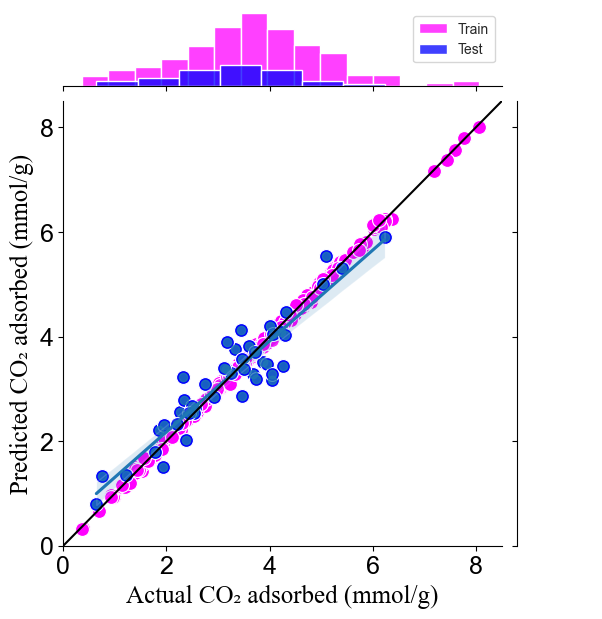

In [38]:
# Say, "the default sans-serif font is COMIC SANS"
import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
label_size = 18
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 


# Then, "ALWAYS use sans-serif fonts"
#matplotlib.rcParams['font.family'] = "sans-serif"

from sklearn.ensemble import GradientBoostingRegressor
model =  GradientBoostingRegressor(learning_rate= 0.05, max_depth = 5, min_samples_leaf = 1, min_samples_split = 3, 
                                   n_estimators = 600, subsample = 0.5, random_state=42)

model.fit(x_train_std, y_train)

#Measure the R2 for training and test set
model_score = model.score(x_train_std,y_train)
print("The training R2 is: %.3f" % model.score(x_train_std, y_train))
print("The test R2 is: %.3f "% model.score(x_test_std, y_test))

from sklearn.metrics import mean_squared_error
from math import sqrt

y_predicted = model.predict(x_test_std)
y_predictedtrain = model.predict(x_train_std)
# The mean squared error & Variance
print("MSE-test: %.3f"% mean_squared_error(y_test, y_predicted))
print("RMSE-test: %.3f"% sqrt(mean_squared_error(y_test, y_predicted)))
print("MSE-train: %.3f"% mean_squared_error(y_train, y_predictedtrain))
print("RMSE-train: %.3f"% sqrt(mean_squared_error(y_train, y_predictedtrain)))
print("MAPE: %.3f"% mean_absolute_percentage_error(y_true=y_test, y_pred=y_predicted))

#k-cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model, X = x_train_std, y= y_train, cv=5)
print("The mean training accuracy is: %.3f"% accuracies.mean())

#Plotting the joint plot of  actual v/s predicted
pp_tr = model.predict(x_train_std)

from sklearn.metrics import mean_squared_error, r2_score
g = sns.JointGrid()
sns.set_style("ticks")
sns.scatterplot(x=y_train, y=pp_tr, s=100, color='magenta', ax=g.ax_joint)
sns.scatterplot(x=y_test, y=y_predicted, s=100, color='blue', ax=g.ax_joint)
sns.regplot(x=y_test, y=y_predicted,  ax=g.ax_joint)
sns.set_style("ticks")
plt.ylim(0, 8.5)
plt.xlim(0, 8.5)
g.ax_joint.set_xlim(0, 8.5)

g.set_axis_labels("Actual CO\u2082 adsorbed (mmol/g)", "Predicted CO\u2082 adsorbed (mmol/g)", 
                  fontsize =18, fontname = 'Times New Roman')
sns.histplot(x=y_train,ax=g.ax_marg_x, color ='magenta')
sns.histplot(x=y_test, ax=g.ax_marg_x, color ='blue')
g.ax_marg_x.legend(["Train", "Test"])

#line of equality
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-k')

plt.show()


The training R2 is: 0.999
The test R2 is: 0.883 
MSE-test: 0.157
RMSE-test: 0.396
MSE-train: 0.002
RMSE-train: 0.040
MAPE: 0.116
The mean training accuracy is: 0.806


C:\Program Files\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Program Files\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


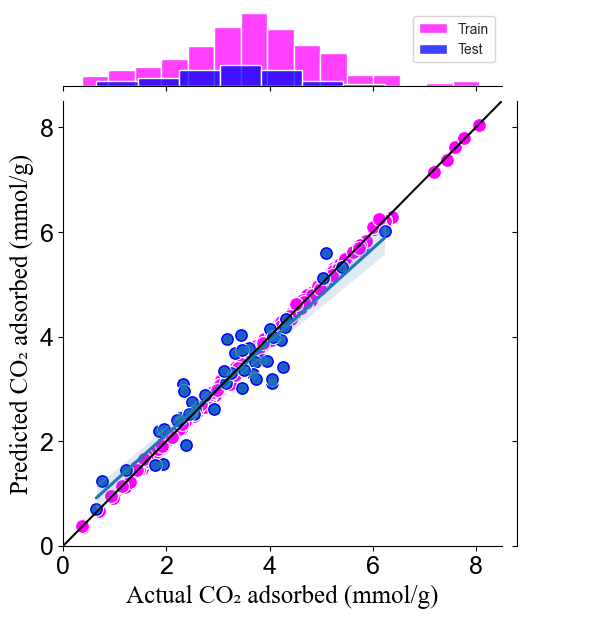

In [31]:
# Fitting optimized new one GBDT Regression to the entire data (original)

# Say, "the default sans-serif font is COMIC SANS"
import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
label_size = 18
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 


# Then, "ALWAYS use sans-serif fonts"
#matplotlib.rcParams['font.family'] = "sans-serif"

from sklearn.ensemble import GradientBoostingRegressor
model =  GradientBoostingRegressor(learning_rate= 0.05, max_depth = 5, min_samples_leaf = 1, min_samples_split = 2, 
                                   n_estimators = 600, subsample = 0.5, random_state=42)

model.fit(x_train_std, y_train)

#Measure the R2 for training and test set
model_score = model.score(x_train_std,y_train)
print("The training R2 is: %.3f" % model.score(x_train_std, y_train))
print("The test R2 is: %.3f "% model.score(x_test_std, y_test))

from sklearn.metrics import mean_squared_error
from math import sqrt

y_predicted = model.predict(x_test_std)
y_predictedtrain = model.predict(x_train_std)
# The mean squared error & Variance
print("MSE-test: %.3f"% mean_squared_error(y_test, y_predicted))
print("RMSE-test: %.3f"% sqrt(mean_squared_error(y_test, y_predicted)))
print("MSE-train: %.3f"% mean_squared_error(y_train, y_predictedtrain))
print("RMSE-train: %.3f"% sqrt(mean_squared_error(y_train, y_predictedtrain)))
print("MAPE: %.3f"% mean_absolute_percentage_error(y_true=y_test, y_pred=y_predicted))

#k-cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model, X = x_train_std, y= y_train, cv=5)
print("The mean training accuracy is: %.3f"% accuracies.mean())

#Plotting the joint plot of  actual v/s predicted
pp_tr = model.predict(x_train_std)

from sklearn.metrics import mean_squared_error, r2_score
g = sns.JointGrid()
sns.set_style("ticks")
sns.scatterplot(x=y_train, y=pp_tr, s=100, color='magenta', ax=g.ax_joint)
sns.scatterplot(x=y_test, y=y_predicted, s=100, color='blue', ax=g.ax_joint)
sns.regplot(x=y_test, y=y_predicted,  ax=g.ax_joint)
sns.set_style("ticks")
plt.ylim(0, 8.5)
plt.xlim(0, 8.5)
g.ax_joint.set_xlim(0, 8.5)

g.set_axis_labels("Actual CO\u2082 adsorbed (mmol/g)", "Predicted CO\u2082 adsorbed (mmol/g)", 
                  fontsize =18, fontname = 'Times New Roman')
sns.histplot(x=y_train,ax=g.ax_marg_x, color ='magenta')
sns.histplot(x=y_test, ax=g.ax_marg_x, color ='blue')
g.ax_marg_x.legend(["Train", "Test"])

#line of equality
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-k')

plt.show()




In [32]:
model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.05,
 'loss': 'squared_error',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 600,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 0.5,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

The training R2 is: 0.999
The test R2 is: 0.829 
MSE-test: 0.230
RMSE-test: 0.479
MSE-train: 0.001
RMSE-train: 0.035
MAPE: 0.142
The mean training accuracy is: 0.783


C:\Program Files\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Program Files\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


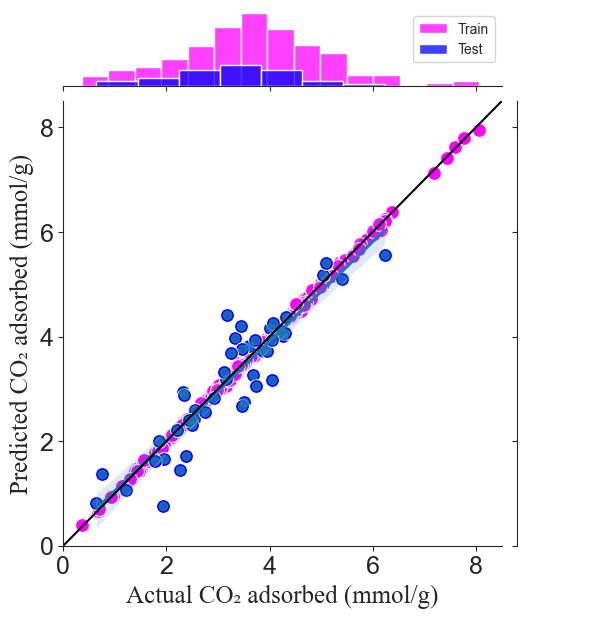

In [33]:
# Fitting optimized new one XGB to the entire data

# Say, "the default sans-serif font is COMIC SANS"
import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
label_size = 18
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 


# Then, "ALWAYS use sans-serif fonts"
#matplotlib.rcParams['font.family'] = "sans-serif"

from xgboost import XGBRegressor
model =  XGBRegressor(colsample_bytree = 1,  eval_metric = 'rmse', 
                        max_depth = 3, n_estimators = 600, seed=70,  subsample = 0.5)

model.fit(x_train_std, y_train)

#Measure the R2 for training and test set
model_score = model.score(x_train_std,y_train)
print("The training R2 is: %.3f" % model.score(x_train_std, y_train))
print("The test R2 is: %.3f "% model.score(x_test_std, y_test))

from sklearn.metrics import mean_squared_error
from math import sqrt

y_predicted = model.predict(x_test_std)
y_predictedtrain = model.predict(x_train_std)
# The mean squared error & Variance
print("MSE-test: %.3f"% mean_squared_error(y_test, y_predicted))
print("RMSE-test: %.3f"% sqrt(mean_squared_error(y_test, y_predicted)))
print("MSE-train: %.3f"% mean_squared_error(y_train, y_predictedtrain))
print("RMSE-train: %.3f"% sqrt(mean_squared_error(y_train, y_predictedtrain)))
print("MAPE: %.3f"% mean_absolute_percentage_error(y_true=y_test, y_pred=y_predicted))

#k-cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model, X = x_train_std, y= y_train, cv=5)
print("The mean training accuracy is: %.3f"% accuracies.mean())

#Plotting the joint plot of  actual v/s predicted
pp_tr = model.predict(x_train_std)

from sklearn.metrics import mean_squared_error, r2_score
g = sns.JointGrid()
sns.set_style("ticks")
sns.scatterplot(x=y_train, y=pp_tr, s=100, color='magenta', ax=g.ax_joint)
sns.scatterplot(x=y_test, y=y_predicted, s=100, color='blue', ax=g.ax_joint)
sns.regplot(x=y_test, y=y_predicted,  ax=g.ax_joint)
sns.set_style("ticks")
plt.ylim(0, 8.5)
plt.xlim(0, 8.5)
g.ax_joint.set_xlim(0, 8.5)

g.set_axis_labels("Actual CO\u2082 adsorbed (mmol/g)", "Predicted CO\u2082 adsorbed (mmol/g)", 
                  fontsize =18, fontname = 'Times New Roman')
sns.histplot(x=y_train,ax=g.ax_marg_x, color ='magenta')
sns.histplot(x=y_test, ax=g.ax_marg_x, color ='blue')
g.ax_marg_x.legend(["Train", "Test"])

#line of equality
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-k')

plt.show()

In [34]:
model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'rmse',
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 600,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.5,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'seed': 70}

The training R2 is: 0.991
The test R2 is: 0.835 
MSE-test: 0.222
RMSE-test: 0.471
MSE-train: 0.018
RMSE-train: 0.134
MAPE: 0.135
The mean training accuracy is: 0.480


C:\Program Files\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Program Files\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


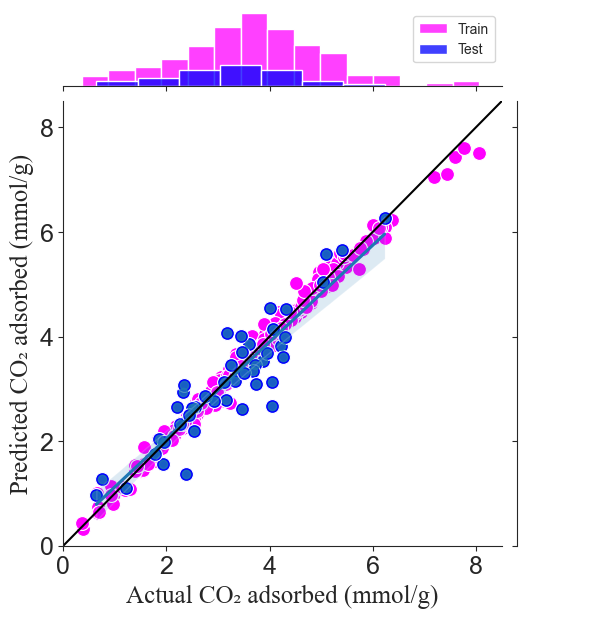

In [35]:
# Fitting optimized new one LBGM Regression to the entire data

# Say, "the default sans-serif font is COMIC SANS"
import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
label_size = 18
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 


# Then, "ALWAYS use sans-serif fonts"
#matplotlib.rcParams['font.family'] = "sans-serif"

from lightgbm import LGBMRegressor
model =  LGBMRegressor( learning_rate = 0.05,
                        max_depth = 10, n_estimators = 600, num_leaves = 9, reg_lambda = 0.8, subsample = 0.1)

model.fit(x_train_std, y_train)

#Measure the R2 for training and test set
model_score = model.score(x_train_std,y_train)
print("The training R2 is: %.3f" % model.score(x_train_std, y_train))
print("The test R2 is: %.3f "% model.score(x_test_std, y_test))

from sklearn.metrics import mean_squared_error
from math import sqrt

y_predicted = model.predict(x_test_std)
y_predictedtrain = model.predict(x_train_std)
# The mean squared error & Variance
print("MSE-test: %.3f"% mean_squared_error(y_test, y_predicted))
print("RMSE-test: %.3f"% sqrt(mean_squared_error(y_test, y_predicted)))
print("MSE-train: %.3f"% mean_squared_error(y_train, y_predictedtrain))
print("RMSE-train: %.3f"% sqrt(mean_squared_error(y_train, y_predictedtrain)))
print("MAPE: %.3f"% mean_absolute_percentage_error(y_true=y_test, y_pred=y_predicted))

#k-cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model, X = x_train_std, y= y_train, cv=5)
print("The mean training accuracy is: %.3f"% accuracies.mean())

#Plotting the joint plot of  actual v/s predicted
pp_tr = model.predict(x_train_std)

from sklearn.metrics import mean_squared_error, r2_score
g = sns.JointGrid()
sns.set_style("ticks")
sns.scatterplot(x=y_train, y=pp_tr, s=100, color='magenta', ax=g.ax_joint)
sns.scatterplot(x=y_test, y=y_predicted, s=100, color='blue', ax=g.ax_joint)
sns.regplot(x=y_test, y=y_predicted,  ax=g.ax_joint)
sns.set_style("ticks")
plt.ylim(0, 8.5)
plt.xlim(0, 8.5)
g.ax_joint.set_xlim(0, 8.5)

g.set_axis_labels("Actual CO\u2082 adsorbed (mmol/g)", "Predicted CO\u2082 adsorbed (mmol/g)", 
                  fontsize =18, fontname = 'Times New Roman')
sns.histplot(x=y_train,ax=g.ax_marg_x, color ='magenta')
sns.histplot(x=y_test, ax=g.ax_marg_x, color ='blue')
g.ax_marg_x.legend(["Train", "Test"])

#line of equality
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-k')

plt.show()

In [36]:
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.05,
 'max_depth': 10,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 600,
 'n_jobs': -1,
 'num_leaves': 9,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.8,
 'silent': 'warn',
 'subsample': 0.1,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

The training R2 is: 0.966
The test R2 is: 0.772 
MSE-test: 0.306
RMSE-test: 0.553
MSE-train: 0.065
RMSE-train: 0.256
MAPE: 0.200
The mean training accuracy is: 0.731


C:\Program Files\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Program Files\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


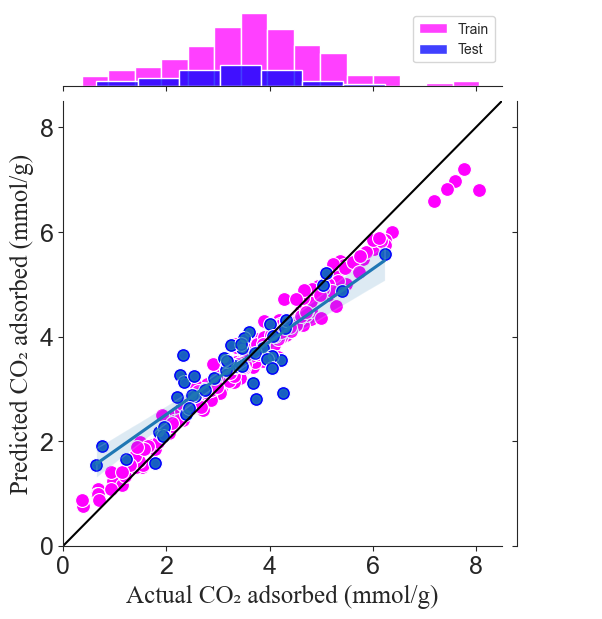

In [37]:
# Fitting optimized new one RF Regression to the entire data

# Say, "the default sans-serif font is COMIC SANS"
import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
label_size = 18
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 


# Then, "ALWAYS use sans-serif fonts"
#matplotlib.rcParams['font.family'] = "sans-serif"

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=900, max_depth=None,bootstrap=True,max_features= 'sqrt')

model.fit(x_train_std, y_train)

#Measure the R2 for training and test set
model_score = model.score(x_train_std,y_train)
print("The training R2 is: %.3f" % model.score(x_train_std, y_train))
print("The test R2 is: %.3f "% model.score(x_test_std, y_test))

from sklearn.metrics import mean_squared_error
from math import sqrt

y_predicted = model.predict(x_test_std)
y_predictedtrain = model.predict(x_train_std)
# The mean squared error & Variance
print("MSE-test: %.3f"% mean_squared_error(y_test, y_predicted))
print("RMSE-test: %.3f"% sqrt(mean_squared_error(y_test, y_predicted)))
print("MSE-train: %.3f"% mean_squared_error(y_train, y_predictedtrain))
print("RMSE-train: %.3f"% sqrt(mean_squared_error(y_train, y_predictedtrain)))
print("MAPE: %.3f"% mean_absolute_percentage_error(y_true=y_test, y_pred=y_predicted))

#k-cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model, X = x_train_std, y= y_train, cv=5)
print("The mean training accuracy is: %.3f"% accuracies.mean())

#Plotting the joint plot of  actual v/s predicted
pp_tr = model.predict(x_train_std)

from sklearn.metrics import mean_squared_error, r2_score
g = sns.JointGrid()
sns.set_style("ticks")
sns.scatterplot(x=y_train, y=pp_tr, s=100, color='magenta', ax=g.ax_joint)
sns.scatterplot(x=y_test, y=y_predicted, s=100, color='blue', ax=g.ax_joint)
sns.regplot(x=y_test, y=y_predicted,  ax=g.ax_joint)
sns.set_style("ticks")
plt.ylim(0, 8.5)
plt.xlim(0, 8.5)
g.ax_joint.set_xlim(0, 8.5)

g.set_axis_labels("Actual CO\u2082 adsorbed (mmol/g)", "Predicted CO\u2082 adsorbed (mmol/g)", 
                  fontsize =18, fontname = 'Times New Roman')
sns.histplot(x=y_train,ax=g.ax_marg_x, color ='magenta')
sns.histplot(x=y_test, ax=g.ax_marg_x, color ='blue')
g.ax_marg_x.legend(["Train", "Test"])

#line of equality
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-k')

plt.show()

In [38]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 900,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Learning rate set to 0.032992
0:	learn: 1.3660884	total: 132ms	remaining: 2m 12s
1:	learn: 1.3420105	total: 133ms	remaining: 1m 6s
2:	learn: 1.3184920	total: 135ms	remaining: 44.8s
3:	learn: 1.2965416	total: 136ms	remaining: 33.8s
4:	learn: 1.2750946	total: 137ms	remaining: 27.2s
5:	learn: 1.2553766	total: 138ms	remaining: 22.9s
6:	learn: 1.2377359	total: 139ms	remaining: 19.7s
7:	learn: 1.2191966	total: 140ms	remaining: 17.4s
8:	learn: 1.2001918	total: 142ms	remaining: 15.6s
9:	learn: 1.1832349	total: 143ms	remaining: 14.1s
10:	learn: 1.1665828	total: 144ms	remaining: 13s
11:	learn: 1.1495898	total: 146ms	remaining: 12s
12:	learn: 1.1342308	total: 147ms	remaining: 11.1s
13:	learn: 1.1178260	total: 148ms	remaining: 10.4s
14:	learn: 1.1019016	total: 149ms	remaining: 9.78s
15:	learn: 1.0871674	total: 150ms	remaining: 9.22s
16:	learn: 1.0722610	total: 151ms	remaining: 8.73s
17:	learn: 1.0574345	total: 152ms	remaining: 8.29s
18:	learn: 1.0457791	total: 153ms	remaining: 7.9s
19:	learn: 1.03

224:	learn: 0.3594803	total: 394ms	remaining: 1.36s
225:	learn: 0.3579574	total: 395ms	remaining: 1.35s
226:	learn: 0.3570257	total: 396ms	remaining: 1.35s
227:	learn: 0.3567354	total: 397ms	remaining: 1.34s
228:	learn: 0.3558833	total: 398ms	remaining: 1.34s
229:	learn: 0.3552925	total: 399ms	remaining: 1.34s
230:	learn: 0.3544066	total: 400ms	remaining: 1.33s
231:	learn: 0.3538412	total: 401ms	remaining: 1.33s
232:	learn: 0.3531510	total: 402ms	remaining: 1.32s
233:	learn: 0.3522405	total: 403ms	remaining: 1.32s
234:	learn: 0.3510783	total: 404ms	remaining: 1.31s
235:	learn: 0.3497213	total: 405ms	remaining: 1.31s
236:	learn: 0.3473997	total: 406ms	remaining: 1.31s
237:	learn: 0.3467986	total: 407ms	remaining: 1.3s
238:	learn: 0.3463342	total: 408ms	remaining: 1.3s
239:	learn: 0.3459163	total: 409ms	remaining: 1.3s
240:	learn: 0.3443172	total: 410ms	remaining: 1.29s
241:	learn: 0.3433101	total: 411ms	remaining: 1.29s
242:	learn: 0.3429250	total: 412ms	remaining: 1.28s
243:	learn: 0.3

424:	learn: 0.2071457	total: 583ms	remaining: 789ms
425:	learn: 0.2070952	total: 584ms	remaining: 787ms
426:	learn: 0.2066461	total: 585ms	remaining: 785ms
427:	learn: 0.2061487	total: 586ms	remaining: 783ms
428:	learn: 0.2055633	total: 587ms	remaining: 781ms
429:	learn: 0.2054003	total: 588ms	remaining: 779ms
430:	learn: 0.2048339	total: 589ms	remaining: 777ms
431:	learn: 0.2046591	total: 590ms	remaining: 775ms
432:	learn: 0.2042672	total: 591ms	remaining: 774ms
433:	learn: 0.2037907	total: 592ms	remaining: 772ms
434:	learn: 0.2034371	total: 593ms	remaining: 770ms
435:	learn: 0.2031430	total: 593ms	remaining: 768ms
436:	learn: 0.2025292	total: 594ms	remaining: 766ms
437:	learn: 0.2022495	total: 596ms	remaining: 764ms
438:	learn: 0.2015155	total: 597ms	remaining: 762ms
439:	learn: 0.2008377	total: 598ms	remaining: 761ms
440:	learn: 0.2002731	total: 599ms	remaining: 759ms
441:	learn: 0.1996483	total: 600ms	remaining: 757ms
442:	learn: 0.1989475	total: 601ms	remaining: 755ms
443:	learn: 

625:	learn: 0.1365641	total: 772ms	remaining: 461ms
626:	learn: 0.1363014	total: 773ms	remaining: 460ms
627:	learn: 0.1359932	total: 774ms	remaining: 458ms
628:	learn: 0.1355757	total: 775ms	remaining: 457ms
629:	learn: 0.1352753	total: 776ms	remaining: 456ms
630:	learn: 0.1347275	total: 777ms	remaining: 454ms
631:	learn: 0.1344980	total: 778ms	remaining: 453ms
632:	learn: 0.1342637	total: 779ms	remaining: 451ms
633:	learn: 0.1341000	total: 780ms	remaining: 450ms
634:	learn: 0.1337967	total: 781ms	remaining: 449ms
635:	learn: 0.1335804	total: 782ms	remaining: 447ms
636:	learn: 0.1333159	total: 783ms	remaining: 446ms
637:	learn: 0.1331611	total: 784ms	remaining: 445ms
638:	learn: 0.1328753	total: 785ms	remaining: 443ms
639:	learn: 0.1326039	total: 786ms	remaining: 442ms
640:	learn: 0.1323813	total: 787ms	remaining: 441ms
641:	learn: 0.1322294	total: 788ms	remaining: 439ms
642:	learn: 0.1318630	total: 788ms	remaining: 438ms
643:	learn: 0.1317087	total: 789ms	remaining: 436ms
644:	learn: 

828:	learn: 0.0956844	total: 964ms	remaining: 199ms
829:	learn: 0.0954761	total: 965ms	remaining: 198ms
830:	learn: 0.0952254	total: 966ms	remaining: 196ms
831:	learn: 0.0950048	total: 967ms	remaining: 195ms
832:	learn: 0.0947977	total: 969ms	remaining: 194ms
833:	learn: 0.0946871	total: 970ms	remaining: 193ms
834:	learn: 0.0945406	total: 971ms	remaining: 192ms
835:	learn: 0.0944730	total: 972ms	remaining: 191ms
836:	learn: 0.0941983	total: 973ms	remaining: 189ms
837:	learn: 0.0939914	total: 974ms	remaining: 188ms
838:	learn: 0.0937869	total: 975ms	remaining: 187ms
839:	learn: 0.0936945	total: 976ms	remaining: 186ms
840:	learn: 0.0935876	total: 977ms	remaining: 185ms
841:	learn: 0.0935295	total: 978ms	remaining: 183ms
842:	learn: 0.0933913	total: 979ms	remaining: 182ms
843:	learn: 0.0932781	total: 980ms	remaining: 181ms
844:	learn: 0.0931659	total: 981ms	remaining: 180ms
845:	learn: 0.0930271	total: 982ms	remaining: 179ms
846:	learn: 0.0928864	total: 983ms	remaining: 178ms
847:	learn: 

The training R2 is: 0.997
The test R2 is: 0.856 
MSE-test: 0.193
RMSE-test: 0.439
MSE-train: 0.005
RMSE-train: 0.073
MAPE: 0.150
Learning rate set to 0.031849
0:	learn: 1.3556437	total: 3.31ms	remaining: 3.31s
1:	learn: 1.3318799	total: 7.39ms	remaining: 3.69s
2:	learn: 1.3095970	total: 11ms	remaining: 3.67s
3:	learn: 1.2898490	total: 13.9ms	remaining: 3.47s
4:	learn: 1.2696644	total: 16.6ms	remaining: 3.3s
5:	learn: 1.2540782	total: 19.4ms	remaining: 3.22s
6:	learn: 1.2370744	total: 21.5ms	remaining: 3.04s
7:	learn: 1.2192898	total: 23.4ms	remaining: 2.9s
8:	learn: 1.2016457	total: 25.3ms	remaining: 2.79s
9:	learn: 1.1853104	total: 26.9ms	remaining: 2.67s
10:	learn: 1.1697378	total: 28.5ms	remaining: 2.56s
11:	learn: 1.1540470	total: 30.1ms	remaining: 2.48s
12:	learn: 1.1405030	total: 31.8ms	remaining: 2.41s
13:	learn: 1.1253857	total: 33.1ms	remaining: 2.33s
14:	learn: 1.1104188	total: 34.5ms	remaining: 2.27s
15:	learn: 1.0967305	total: 36ms	remaining: 2.21s
16:	learn: 1.0812046	tota

179:	learn: 0.3988780	total: 176ms	remaining: 800ms
180:	learn: 0.3975178	total: 176ms	remaining: 798ms
181:	learn: 0.3964228	total: 177ms	remaining: 797ms
182:	learn: 0.3937493	total: 178ms	remaining: 795ms
183:	learn: 0.3920371	total: 179ms	remaining: 794ms
184:	learn: 0.3892620	total: 180ms	remaining: 792ms
185:	learn: 0.3872022	total: 181ms	remaining: 790ms
186:	learn: 0.3856823	total: 182ms	remaining: 789ms
187:	learn: 0.3842740	total: 182ms	remaining: 788ms
188:	learn: 0.3820601	total: 183ms	remaining: 786ms
189:	learn: 0.3798688	total: 184ms	remaining: 785ms
190:	learn: 0.3778181	total: 185ms	remaining: 783ms
191:	learn: 0.3765946	total: 186ms	remaining: 782ms
192:	learn: 0.3752815	total: 187ms	remaining: 781ms
193:	learn: 0.3739819	total: 188ms	remaining: 780ms
194:	learn: 0.3729372	total: 188ms	remaining: 778ms
195:	learn: 0.3710864	total: 189ms	remaining: 777ms
196:	learn: 0.3687066	total: 190ms	remaining: 776ms
197:	learn: 0.3675582	total: 191ms	remaining: 774ms
198:	learn: 

408:	learn: 0.1927980	total: 366ms	remaining: 528ms
409:	learn: 0.1919541	total: 367ms	remaining: 527ms
410:	learn: 0.1912713	total: 367ms	remaining: 527ms
411:	learn: 0.1904688	total: 368ms	remaining: 526ms
412:	learn: 0.1902183	total: 369ms	remaining: 525ms
413:	learn: 0.1896318	total: 370ms	remaining: 524ms
414:	learn: 0.1891543	total: 371ms	remaining: 523ms
415:	learn: 0.1885853	total: 372ms	remaining: 522ms
416:	learn: 0.1880275	total: 373ms	remaining: 521ms
417:	learn: 0.1878193	total: 374ms	remaining: 520ms
418:	learn: 0.1877442	total: 374ms	remaining: 519ms
419:	learn: 0.1873090	total: 375ms	remaining: 518ms
420:	learn: 0.1871633	total: 376ms	remaining: 517ms
421:	learn: 0.1865144	total: 377ms	remaining: 516ms
422:	learn: 0.1860051	total: 378ms	remaining: 516ms
423:	learn: 0.1854746	total: 379ms	remaining: 515ms
424:	learn: 0.1850781	total: 380ms	remaining: 514ms
425:	learn: 0.1846999	total: 381ms	remaining: 513ms
426:	learn: 0.1840414	total: 382ms	remaining: 512ms
427:	learn: 

622:	learn: 0.1121761	total: 556ms	remaining: 336ms
623:	learn: 0.1118361	total: 557ms	remaining: 335ms
624:	learn: 0.1116494	total: 558ms	remaining: 335ms
625:	learn: 0.1114171	total: 559ms	remaining: 334ms
626:	learn: 0.1111137	total: 560ms	remaining: 333ms
627:	learn: 0.1109422	total: 561ms	remaining: 332ms
628:	learn: 0.1106386	total: 562ms	remaining: 331ms
629:	learn: 0.1105447	total: 563ms	remaining: 330ms
630:	learn: 0.1104050	total: 563ms	remaining: 329ms
631:	learn: 0.1100662	total: 564ms	remaining: 329ms
632:	learn: 0.1098835	total: 565ms	remaining: 328ms
633:	learn: 0.1096614	total: 566ms	remaining: 327ms
634:	learn: 0.1095269	total: 567ms	remaining: 326ms
635:	learn: 0.1091341	total: 568ms	remaining: 325ms
636:	learn: 0.1089406	total: 569ms	remaining: 324ms
637:	learn: 0.1086671	total: 570ms	remaining: 323ms
638:	learn: 0.1085216	total: 571ms	remaining: 323ms
639:	learn: 0.1083342	total: 572ms	remaining: 322ms
640:	learn: 0.1081752	total: 573ms	remaining: 321ms
641:	learn: 

831:	learn: 0.0699286	total: 748ms	remaining: 151ms
832:	learn: 0.0698247	total: 749ms	remaining: 150ms
833:	learn: 0.0697121	total: 750ms	remaining: 149ms
834:	learn: 0.0696087	total: 751ms	remaining: 148ms
835:	learn: 0.0695183	total: 752ms	remaining: 148ms
836:	learn: 0.0694067	total: 753ms	remaining: 147ms
837:	learn: 0.0692810	total: 754ms	remaining: 146ms
838:	learn: 0.0692016	total: 755ms	remaining: 145ms
839:	learn: 0.0690762	total: 756ms	remaining: 144ms
840:	learn: 0.0689116	total: 757ms	remaining: 143ms
841:	learn: 0.0688401	total: 758ms	remaining: 142ms
842:	learn: 0.0687173	total: 759ms	remaining: 141ms
843:	learn: 0.0685714	total: 760ms	remaining: 140ms
844:	learn: 0.0684140	total: 761ms	remaining: 140ms
845:	learn: 0.0682200	total: 762ms	remaining: 139ms
846:	learn: 0.0679975	total: 763ms	remaining: 138ms
847:	learn: 0.0679249	total: 764ms	remaining: 137ms
848:	learn: 0.0678018	total: 765ms	remaining: 136ms
849:	learn: 0.0676503	total: 766ms	remaining: 135ms
850:	learn: 

0:	learn: 1.3957131	total: 1.17ms	remaining: 1.17s
1:	learn: 1.3749539	total: 2.18ms	remaining: 1.09s
2:	learn: 1.3535820	total: 3.02ms	remaining: 1s
3:	learn: 1.3331197	total: 3.91ms	remaining: 974ms
4:	learn: 1.3144542	total: 4.89ms	remaining: 974ms
5:	learn: 1.2972028	total: 5.81ms	remaining: 962ms
6:	learn: 1.2804598	total: 6.67ms	remaining: 946ms
7:	learn: 1.2636767	total: 7.55ms	remaining: 936ms
8:	learn: 1.2476094	total: 8.44ms	remaining: 929ms
9:	learn: 1.2319562	total: 9.33ms	remaining: 924ms
10:	learn: 1.2166291	total: 10.3ms	remaining: 923ms
11:	learn: 1.2010443	total: 11.2ms	remaining: 926ms
12:	learn: 1.1858677	total: 12.2ms	remaining: 927ms
13:	learn: 1.1696437	total: 13ms	remaining: 916ms
14:	learn: 1.1547631	total: 13.8ms	remaining: 908ms
15:	learn: 1.1402242	total: 14.9ms	remaining: 914ms
16:	learn: 1.1247720	total: 15.7ms	remaining: 907ms
17:	learn: 1.1114941	total: 16.5ms	remaining: 900ms
18:	learn: 1.1016731	total: 17.3ms	remaining: 893ms
19:	learn: 1.0884230	total:

229:	learn: 0.3597646	total: 190ms	remaining: 637ms
230:	learn: 0.3575686	total: 191ms	remaining: 637ms
231:	learn: 0.3568544	total: 192ms	remaining: 637ms
232:	learn: 0.3556134	total: 193ms	remaining: 636ms
233:	learn: 0.3549113	total: 194ms	remaining: 635ms
234:	learn: 0.3541120	total: 195ms	remaining: 635ms
235:	learn: 0.3533988	total: 196ms	remaining: 634ms
236:	learn: 0.3525780	total: 197ms	remaining: 633ms
237:	learn: 0.3511490	total: 197ms	remaining: 632ms
238:	learn: 0.3504784	total: 198ms	remaining: 631ms
239:	learn: 0.3496026	total: 199ms	remaining: 630ms
240:	learn: 0.3488181	total: 200ms	remaining: 629ms
241:	learn: 0.3480479	total: 201ms	remaining: 629ms
242:	learn: 0.3470099	total: 202ms	remaining: 628ms
243:	learn: 0.3451987	total: 202ms	remaining: 627ms
244:	learn: 0.3436877	total: 203ms	remaining: 626ms
245:	learn: 0.3429845	total: 204ms	remaining: 626ms
246:	learn: 0.3425837	total: 205ms	remaining: 625ms
247:	learn: 0.3417743	total: 206ms	remaining: 625ms
248:	learn: 

468:	learn: 0.1732508	total: 383ms	remaining: 434ms
469:	learn: 0.1727592	total: 384ms	remaining: 433ms
470:	learn: 0.1723805	total: 385ms	remaining: 433ms
471:	learn: 0.1717644	total: 386ms	remaining: 432ms
472:	learn: 0.1714409	total: 387ms	remaining: 431ms
473:	learn: 0.1709412	total: 388ms	remaining: 430ms
474:	learn: 0.1705557	total: 389ms	remaining: 429ms
475:	learn: 0.1705191	total: 390ms	remaining: 429ms
476:	learn: 0.1698855	total: 390ms	remaining: 428ms
477:	learn: 0.1693223	total: 391ms	remaining: 427ms
478:	learn: 0.1690060	total: 392ms	remaining: 426ms
479:	learn: 0.1687397	total: 393ms	remaining: 426ms
480:	learn: 0.1683291	total: 394ms	remaining: 425ms
481:	learn: 0.1682783	total: 395ms	remaining: 424ms
482:	learn: 0.1678903	total: 396ms	remaining: 423ms
483:	learn: 0.1673059	total: 397ms	remaining: 423ms
484:	learn: 0.1669744	total: 397ms	remaining: 422ms
485:	learn: 0.1664454	total: 398ms	remaining: 421ms
486:	learn: 0.1663661	total: 399ms	remaining: 420ms
487:	learn: 

702:	learn: 0.1004454	total: 575ms	remaining: 243ms
703:	learn: 0.1001752	total: 576ms	remaining: 242ms
704:	learn: 0.0999845	total: 577ms	remaining: 242ms
705:	learn: 0.0996841	total: 578ms	remaining: 241ms
706:	learn: 0.0993725	total: 579ms	remaining: 240ms
707:	learn: 0.0992828	total: 580ms	remaining: 239ms
708:	learn: 0.0990659	total: 581ms	remaining: 238ms
709:	learn: 0.0987651	total: 581ms	remaining: 237ms
710:	learn: 0.0987345	total: 582ms	remaining: 237ms
711:	learn: 0.0985497	total: 583ms	remaining: 236ms
712:	learn: 0.0984001	total: 584ms	remaining: 235ms
713:	learn: 0.0982322	total: 585ms	remaining: 234ms
714:	learn: 0.0982028	total: 586ms	remaining: 233ms
715:	learn: 0.0980905	total: 586ms	remaining: 233ms
716:	learn: 0.0978977	total: 587ms	remaining: 232ms
717:	learn: 0.0975942	total: 588ms	remaining: 231ms
718:	learn: 0.0973941	total: 589ms	remaining: 230ms
719:	learn: 0.0971339	total: 590ms	remaining: 230ms
720:	learn: 0.0969579	total: 591ms	remaining: 229ms
721:	learn: 

931:	learn: 0.0653751	total: 767ms	remaining: 55.9ms
932:	learn: 0.0652949	total: 768ms	remaining: 55.1ms
933:	learn: 0.0652795	total: 769ms	remaining: 54.3ms
934:	learn: 0.0652299	total: 770ms	remaining: 53.5ms
935:	learn: 0.0651219	total: 770ms	remaining: 52.7ms
936:	learn: 0.0648972	total: 771ms	remaining: 51.9ms
937:	learn: 0.0647267	total: 772ms	remaining: 51ms
938:	learn: 0.0647054	total: 773ms	remaining: 50.2ms
939:	learn: 0.0646724	total: 774ms	remaining: 49.4ms
940:	learn: 0.0645661	total: 775ms	remaining: 48.6ms
941:	learn: 0.0644566	total: 776ms	remaining: 47.8ms
942:	learn: 0.0643644	total: 777ms	remaining: 47ms
943:	learn: 0.0642182	total: 778ms	remaining: 46.1ms
944:	learn: 0.0642026	total: 779ms	remaining: 45.3ms
945:	learn: 0.0641236	total: 780ms	remaining: 44.5ms
946:	learn: 0.0640840	total: 781ms	remaining: 43.7ms
947:	learn: 0.0639365	total: 782ms	remaining: 42.9ms
948:	learn: 0.0637691	total: 782ms	remaining: 42ms
949:	learn: 0.0635942	total: 783ms	remaining: 41.2ms

121:	learn: 0.5350126	total: 97.6ms	remaining: 703ms
122:	learn: 0.5328567	total: 98.5ms	remaining: 702ms
123:	learn: 0.5305913	total: 99.4ms	remaining: 702ms
124:	learn: 0.5278323	total: 100ms	remaining: 702ms
125:	learn: 0.5259013	total: 101ms	remaining: 703ms
126:	learn: 0.5233364	total: 102ms	remaining: 703ms
127:	learn: 0.5210067	total: 103ms	remaining: 702ms
128:	learn: 0.5191109	total: 104ms	remaining: 702ms
129:	learn: 0.5163923	total: 105ms	remaining: 702ms
130:	learn: 0.5149032	total: 106ms	remaining: 701ms
131:	learn: 0.5128551	total: 107ms	remaining: 701ms
132:	learn: 0.5110291	total: 107ms	remaining: 700ms
133:	learn: 0.5088715	total: 108ms	remaining: 699ms
134:	learn: 0.5068548	total: 109ms	remaining: 699ms
135:	learn: 0.5057684	total: 109ms	remaining: 696ms
136:	learn: 0.5032201	total: 110ms	remaining: 695ms
137:	learn: 0.5004182	total: 111ms	remaining: 695ms
138:	learn: 0.4985090	total: 112ms	remaining: 695ms
139:	learn: 0.4962906	total: 113ms	remaining: 695ms
140:	lear

335:	learn: 0.2500898	total: 283ms	remaining: 559ms
336:	learn: 0.2489028	total: 284ms	remaining: 559ms
337:	learn: 0.2474611	total: 285ms	remaining: 558ms
338:	learn: 0.2470466	total: 286ms	remaining: 558ms
339:	learn: 0.2460036	total: 287ms	remaining: 557ms
340:	learn: 0.2458471	total: 288ms	remaining: 557ms
341:	learn: 0.2452538	total: 289ms	remaining: 556ms
342:	learn: 0.2443146	total: 290ms	remaining: 555ms
343:	learn: 0.2434197	total: 291ms	remaining: 555ms
344:	learn: 0.2422924	total: 292ms	remaining: 554ms
345:	learn: 0.2420190	total: 293ms	remaining: 553ms
346:	learn: 0.2414555	total: 293ms	remaining: 552ms
347:	learn: 0.2405316	total: 294ms	remaining: 551ms
348:	learn: 0.2402413	total: 295ms	remaining: 551ms
349:	learn: 0.2400911	total: 296ms	remaining: 550ms
350:	learn: 0.2399555	total: 297ms	remaining: 549ms
351:	learn: 0.2388281	total: 298ms	remaining: 549ms
352:	learn: 0.2385569	total: 299ms	remaining: 548ms
353:	learn: 0.2384261	total: 300ms	remaining: 547ms
354:	learn: 

540:	learn: 0.1570416	total: 475ms	remaining: 403ms
541:	learn: 0.1563220	total: 476ms	remaining: 402ms
542:	learn: 0.1560882	total: 477ms	remaining: 401ms
543:	learn: 0.1555039	total: 478ms	remaining: 400ms
544:	learn: 0.1550205	total: 479ms	remaining: 400ms
545:	learn: 0.1543886	total: 479ms	remaining: 399ms
546:	learn: 0.1541622	total: 480ms	remaining: 398ms
547:	learn: 0.1538606	total: 481ms	remaining: 397ms
548:	learn: 0.1535633	total: 482ms	remaining: 396ms
549:	learn: 0.1529250	total: 483ms	remaining: 395ms
550:	learn: 0.1528974	total: 484ms	remaining: 394ms
551:	learn: 0.1526088	total: 485ms	remaining: 393ms
552:	learn: 0.1522986	total: 485ms	remaining: 392ms
553:	learn: 0.1517873	total: 486ms	remaining: 391ms
554:	learn: 0.1516278	total: 487ms	remaining: 391ms
555:	learn: 0.1515960	total: 488ms	remaining: 390ms
556:	learn: 0.1513441	total: 489ms	remaining: 389ms
557:	learn: 0.1507328	total: 490ms	remaining: 388ms
558:	learn: 0.1504211	total: 491ms	remaining: 387ms
559:	learn: 

767:	learn: 0.0971601	total: 664ms	remaining: 201ms
768:	learn: 0.0969241	total: 665ms	remaining: 200ms
769:	learn: 0.0966204	total: 666ms	remaining: 199ms
770:	learn: 0.0965098	total: 667ms	remaining: 198ms
771:	learn: 0.0963624	total: 667ms	remaining: 197ms
772:	learn: 0.0962022	total: 668ms	remaining: 196ms
773:	learn: 0.0960295	total: 669ms	remaining: 195ms
774:	learn: 0.0957229	total: 670ms	remaining: 195ms
775:	learn: 0.0955850	total: 671ms	remaining: 194ms
776:	learn: 0.0953062	total: 672ms	remaining: 193ms
777:	learn: 0.0952809	total: 673ms	remaining: 192ms
778:	learn: 0.0949040	total: 673ms	remaining: 191ms
779:	learn: 0.0947919	total: 674ms	remaining: 190ms
780:	learn: 0.0946882	total: 675ms	remaining: 189ms
781:	learn: 0.0943742	total: 676ms	remaining: 188ms
782:	learn: 0.0942581	total: 677ms	remaining: 188ms
783:	learn: 0.0942360	total: 678ms	remaining: 187ms
784:	learn: 0.0940854	total: 679ms	remaining: 186ms
785:	learn: 0.0939939	total: 680ms	remaining: 185ms
786:	learn: 

995:	learn: 0.0648908	total: 855ms	remaining: 3.43ms
996:	learn: 0.0647864	total: 856ms	remaining: 2.58ms
997:	learn: 0.0646833	total: 857ms	remaining: 1.72ms
998:	learn: 0.0645432	total: 858ms	remaining: 858us
999:	learn: 0.0644702	total: 859ms	remaining: 0us
Learning rate set to 0.031849
0:	learn: 1.3436481	total: 867us	remaining: 867ms
1:	learn: 1.3223221	total: 1.86ms	remaining: 929ms
2:	learn: 1.3012076	total: 2.8ms	remaining: 929ms
3:	learn: 1.2813830	total: 3.67ms	remaining: 915ms
4:	learn: 1.2619612	total: 4.63ms	remaining: 921ms
5:	learn: 1.2476780	total: 5.56ms	remaining: 922ms
6:	learn: 1.2321016	total: 6.5ms	remaining: 922ms
7:	learn: 1.2172209	total: 7.32ms	remaining: 908ms
8:	learn: 1.1989891	total: 8.21ms	remaining: 904ms
9:	learn: 1.1837019	total: 9.14ms	remaining: 905ms
10:	learn: 1.1688293	total: 10ms	remaining: 901ms
11:	learn: 1.1537414	total: 11ms	remaining: 905ms
12:	learn: 1.1404758	total: 12.1ms	remaining: 921ms
13:	learn: 1.1275200	total: 13.1ms	remaining: 920m

182:	learn: 0.4005998	total: 154ms	remaining: 689ms
183:	learn: 0.3986921	total: 155ms	remaining: 688ms
184:	learn: 0.3970510	total: 156ms	remaining: 688ms
185:	learn: 0.3952743	total: 157ms	remaining: 687ms
186:	learn: 0.3935796	total: 158ms	remaining: 686ms
187:	learn: 0.3921760	total: 159ms	remaining: 685ms
188:	learn: 0.3894512	total: 159ms	remaining: 684ms
189:	learn: 0.3881776	total: 160ms	remaining: 683ms
190:	learn: 0.3855803	total: 161ms	remaining: 682ms
191:	learn: 0.3846717	total: 162ms	remaining: 682ms
192:	learn: 0.3833818	total: 163ms	remaining: 681ms
193:	learn: 0.3821434	total: 164ms	remaining: 681ms
194:	learn: 0.3812314	total: 165ms	remaining: 680ms
195:	learn: 0.3790562	total: 166ms	remaining: 679ms
196:	learn: 0.3769136	total: 167ms	remaining: 679ms
197:	learn: 0.3753604	total: 168ms	remaining: 679ms
198:	learn: 0.3729272	total: 168ms	remaining: 678ms
199:	learn: 0.3722390	total: 169ms	remaining: 676ms
200:	learn: 0.3712853	total: 170ms	remaining: 676ms
201:	learn: 

406:	learn: 0.1918276	total: 344ms	remaining: 501ms
407:	learn: 0.1914464	total: 345ms	remaining: 500ms
408:	learn: 0.1905928	total: 346ms	remaining: 500ms
409:	learn: 0.1898436	total: 347ms	remaining: 499ms
410:	learn: 0.1892633	total: 348ms	remaining: 498ms
411:	learn: 0.1887431	total: 348ms	remaining: 497ms
412:	learn: 0.1883727	total: 349ms	remaining: 496ms
413:	learn: 0.1877794	total: 350ms	remaining: 495ms
414:	learn: 0.1872686	total: 351ms	remaining: 495ms
415:	learn: 0.1869843	total: 352ms	remaining: 494ms
416:	learn: 0.1862351	total: 353ms	remaining: 493ms
417:	learn: 0.1858579	total: 354ms	remaining: 492ms
418:	learn: 0.1854103	total: 354ms	remaining: 491ms
419:	learn: 0.1845602	total: 355ms	remaining: 491ms
420:	learn: 0.1839711	total: 356ms	remaining: 490ms
421:	learn: 0.1835086	total: 357ms	remaining: 489ms
422:	learn: 0.1830899	total: 358ms	remaining: 488ms
423:	learn: 0.1825300	total: 359ms	remaining: 488ms
424:	learn: 0.1823251	total: 360ms	remaining: 487ms
425:	learn: 

630:	learn: 0.1165625	total: 535ms	remaining: 313ms
631:	learn: 0.1161785	total: 536ms	remaining: 312ms
632:	learn: 0.1158480	total: 537ms	remaining: 311ms
633:	learn: 0.1157246	total: 538ms	remaining: 311ms
634:	learn: 0.1155284	total: 539ms	remaining: 310ms
635:	learn: 0.1153794	total: 540ms	remaining: 309ms
636:	learn: 0.1152485	total: 540ms	remaining: 308ms
637:	learn: 0.1148759	total: 541ms	remaining: 307ms
638:	learn: 0.1146141	total: 542ms	remaining: 306ms
639:	learn: 0.1142091	total: 543ms	remaining: 306ms
640:	learn: 0.1140116	total: 544ms	remaining: 305ms
641:	learn: 0.1139991	total: 545ms	remaining: 304ms
642:	learn: 0.1138515	total: 546ms	remaining: 303ms
643:	learn: 0.1135418	total: 547ms	remaining: 302ms
644:	learn: 0.1132128	total: 548ms	remaining: 301ms
645:	learn: 0.1129000	total: 548ms	remaining: 301ms
646:	learn: 0.1126413	total: 549ms	remaining: 300ms
647:	learn: 0.1123769	total: 550ms	remaining: 299ms
648:	learn: 0.1121585	total: 551ms	remaining: 298ms
649:	learn: 

854:	learn: 0.0716486	total: 727ms	remaining: 123ms
855:	learn: 0.0715055	total: 728ms	remaining: 122ms
856:	learn: 0.0714206	total: 729ms	remaining: 122ms
857:	learn: 0.0712752	total: 730ms	remaining: 121ms
858:	learn: 0.0711392	total: 731ms	remaining: 120ms
859:	learn: 0.0708855	total: 731ms	remaining: 119ms
860:	learn: 0.0708046	total: 732ms	remaining: 118ms
861:	learn: 0.0705455	total: 733ms	remaining: 117ms
862:	learn: 0.0703697	total: 734ms	remaining: 117ms
863:	learn: 0.0702810	total: 735ms	remaining: 116ms
864:	learn: 0.0701456	total: 736ms	remaining: 115ms
865:	learn: 0.0699828	total: 736ms	remaining: 114ms
866:	learn: 0.0698667	total: 737ms	remaining: 113ms
867:	learn: 0.0697394	total: 738ms	remaining: 112ms
868:	learn: 0.0695703	total: 739ms	remaining: 111ms
869:	learn: 0.0694275	total: 740ms	remaining: 111ms
870:	learn: 0.0692908	total: 741ms	remaining: 110ms
871:	learn: 0.0691262	total: 742ms	remaining: 109ms
872:	learn: 0.0689512	total: 743ms	remaining: 108ms
873:	learn: 

34:	learn: 0.8984713	total: 27.4ms	remaining: 756ms
35:	learn: 0.8886599	total: 28ms	remaining: 750ms
36:	learn: 0.8796095	total: 28.9ms	remaining: 752ms
37:	learn: 0.8719445	total: 29.9ms	remaining: 756ms
38:	learn: 0.8632102	total: 30.7ms	remaining: 756ms
39:	learn: 0.8567403	total: 31.6ms	remaining: 757ms
40:	learn: 0.8504163	total: 32.4ms	remaining: 759ms
41:	learn: 0.8436588	total: 33.3ms	remaining: 760ms
42:	learn: 0.8352873	total: 34.2ms	remaining: 761ms
43:	learn: 0.8268923	total: 35.1ms	remaining: 762ms
44:	learn: 0.8176762	total: 36.1ms	remaining: 766ms
45:	learn: 0.8091346	total: 37ms	remaining: 767ms
46:	learn: 0.8006993	total: 37.9ms	remaining: 768ms
47:	learn: 0.7940038	total: 38.7ms	remaining: 768ms
48:	learn: 0.7873678	total: 39.6ms	remaining: 769ms
49:	learn: 0.7804310	total: 40.8ms	remaining: 776ms
50:	learn: 0.7738837	total: 41.8ms	remaining: 778ms
51:	learn: 0.7684852	total: 42.3ms	remaining: 771ms
52:	learn: 0.7611206	total: 43.2ms	remaining: 772ms
53:	learn: 0.755

269:	learn: 0.2913672	total: 225ms	remaining: 608ms
270:	learn: 0.2898150	total: 226ms	remaining: 608ms
271:	learn: 0.2885377	total: 227ms	remaining: 607ms
272:	learn: 0.2874960	total: 228ms	remaining: 606ms
273:	learn: 0.2871609	total: 229ms	remaining: 606ms
274:	learn: 0.2869550	total: 229ms	remaining: 605ms
275:	learn: 0.2856778	total: 230ms	remaining: 604ms
276:	learn: 0.2841263	total: 231ms	remaining: 604ms
277:	learn: 0.2838899	total: 232ms	remaining: 603ms
278:	learn: 0.2826760	total: 233ms	remaining: 602ms
279:	learn: 0.2818359	total: 234ms	remaining: 602ms
280:	learn: 0.2814172	total: 235ms	remaining: 601ms
281:	learn: 0.2802701	total: 236ms	remaining: 601ms
282:	learn: 0.2789384	total: 237ms	remaining: 600ms
283:	learn: 0.2779671	total: 238ms	remaining: 600ms
284:	learn: 0.2772334	total: 239ms	remaining: 600ms
285:	learn: 0.2765270	total: 240ms	remaining: 599ms
286:	learn: 0.2752940	total: 241ms	remaining: 599ms
287:	learn: 0.2739439	total: 242ms	remaining: 598ms
288:	learn: 

497:	learn: 0.1554822	total: 421ms	remaining: 424ms
498:	learn: 0.1551167	total: 422ms	remaining: 424ms
499:	learn: 0.1550325	total: 423ms	remaining: 423ms
500:	learn: 0.1544956	total: 424ms	remaining: 422ms
501:	learn: 0.1541701	total: 425ms	remaining: 421ms
502:	learn: 0.1539287	total: 425ms	remaining: 420ms
503:	learn: 0.1538049	total: 426ms	remaining: 420ms
504:	learn: 0.1535264	total: 427ms	remaining: 419ms
505:	learn: 0.1532844	total: 428ms	remaining: 418ms
506:	learn: 0.1529946	total: 429ms	remaining: 417ms
507:	learn: 0.1528417	total: 430ms	remaining: 416ms
508:	learn: 0.1524398	total: 431ms	remaining: 415ms
509:	learn: 0.1523107	total: 431ms	remaining: 414ms
510:	learn: 0.1517840	total: 432ms	remaining: 414ms
511:	learn: 0.1513295	total: 433ms	remaining: 413ms
512:	learn: 0.1508241	total: 434ms	remaining: 412ms
513:	learn: 0.1507545	total: 435ms	remaining: 411ms
514:	learn: 0.1505312	total: 436ms	remaining: 410ms
515:	learn: 0.1500418	total: 437ms	remaining: 410ms
516:	learn: 

728:	learn: 0.0967030	total: 619ms	remaining: 230ms
729:	learn: 0.0963764	total: 620ms	remaining: 229ms
730:	learn: 0.0961906	total: 621ms	remaining: 229ms
731:	learn: 0.0961645	total: 622ms	remaining: 228ms
732:	learn: 0.0958408	total: 623ms	remaining: 227ms
733:	learn: 0.0957676	total: 624ms	remaining: 226ms
734:	learn: 0.0957179	total: 624ms	remaining: 225ms
735:	learn: 0.0954981	total: 625ms	remaining: 224ms
736:	learn: 0.0954106	total: 626ms	remaining: 223ms
737:	learn: 0.0950929	total: 627ms	remaining: 223ms
738:	learn: 0.0950757	total: 628ms	remaining: 222ms
739:	learn: 0.0947922	total: 628ms	remaining: 221ms
740:	learn: 0.0944017	total: 629ms	remaining: 220ms
741:	learn: 0.0941351	total: 630ms	remaining: 219ms
742:	learn: 0.0937478	total: 631ms	remaining: 218ms
743:	learn: 0.0935779	total: 632ms	remaining: 217ms
744:	learn: 0.0932591	total: 633ms	remaining: 217ms
745:	learn: 0.0931956	total: 633ms	remaining: 216ms
746:	learn: 0.0930318	total: 634ms	remaining: 215ms
747:	learn: 

964:	learn: 0.0613199	total: 816ms	remaining: 29.6ms
965:	learn: 0.0611881	total: 817ms	remaining: 28.7ms
966:	learn: 0.0611338	total: 818ms	remaining: 27.9ms
967:	learn: 0.0610439	total: 819ms	remaining: 27.1ms
968:	learn: 0.0608701	total: 820ms	remaining: 26.2ms
969:	learn: 0.0606777	total: 820ms	remaining: 25.4ms
970:	learn: 0.0606375	total: 821ms	remaining: 24.5ms
971:	learn: 0.0606117	total: 822ms	remaining: 23.7ms
972:	learn: 0.0605582	total: 823ms	remaining: 22.8ms
973:	learn: 0.0605067	total: 824ms	remaining: 22ms
974:	learn: 0.0604005	total: 825ms	remaining: 21.1ms
975:	learn: 0.0602707	total: 826ms	remaining: 20.3ms
976:	learn: 0.0601015	total: 826ms	remaining: 19.5ms
977:	learn: 0.0600548	total: 827ms	remaining: 18.6ms
978:	learn: 0.0599365	total: 828ms	remaining: 17.8ms
979:	learn: 0.0599153	total: 829ms	remaining: 16.9ms
980:	learn: 0.0597556	total: 830ms	remaining: 16.1ms
981:	learn: 0.0596994	total: 831ms	remaining: 15.2ms
982:	learn: 0.0595636	total: 832ms	remaining: 14

C:\Program Files\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Program Files\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


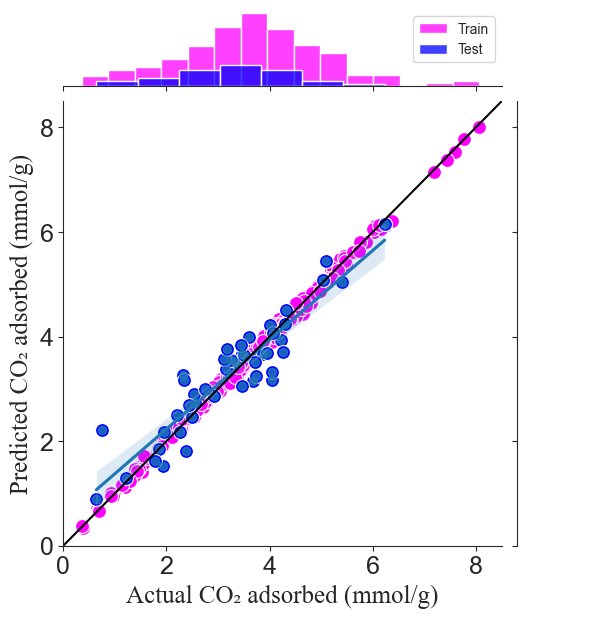

In [39]:
# Fitting optimized new one CB Regression to the entire data

# Say, "the default sans-serif font is COMIC SANS"
import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
label_size = 18
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 


# Then, "ALWAYS use sans-serif fonts"
#matplotlib.rcParams['font.family'] = "sans-serif"

model = cb.CatBoostRegressor(loss_function='RMSE')

model.fit(x_train_std, y_train)

#Measure the R2 for training and test set
model_score = model.score(x_train_std,y_train)
print("The training R2 is: %.3f" % model.score(x_train_std, y_train))
print("The test R2 is: %.3f "% model.score(x_test_std, y_test))

from sklearn.metrics import mean_squared_error
from math import sqrt

y_predicted = model.predict(x_test_std)
y_predictedtrain = model.predict(x_train_std)
# The mean squared error & Variance
print("MSE-test: %.3f"% mean_squared_error(y_test, y_predicted))
print("RMSE-test: %.3f"% sqrt(mean_squared_error(y_test, y_predicted)))
print("MSE-train: %.3f"% mean_squared_error(y_train, y_predictedtrain))
print("RMSE-train: %.3f"% sqrt(mean_squared_error(y_train, y_predictedtrain)))
print("MAPE: %.3f"% mean_absolute_percentage_error(y_true=y_test, y_pred=y_predicted))

#k-cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model, X = x_train_std, y= y_train, cv=5)
print("The mean training accuracy is: %.3f"% accuracies.mean())

#Plotting the joint plot of  actual v/s predicted
pp_tr = model.predict(x_train_std)

from sklearn.metrics import mean_squared_error, r2_score
g = sns.JointGrid()
sns.set_style("ticks")
sns.scatterplot(x=y_train, y=pp_tr, s=100, color='magenta', ax=g.ax_joint)
sns.scatterplot(x=y_test, y=y_predicted, s=100, color='blue', ax=g.ax_joint)
sns.regplot(x=y_test, y=y_predicted,  ax=g.ax_joint)
sns.set_style("ticks")
plt.ylim(0, 8.5)
plt.xlim(0, 8.5)
g.ax_joint.set_xlim(0, 8.5)

g.set_axis_labels("Actual CO\u2082 adsorbed (mmol/g)", "Predicted CO\u2082 adsorbed (mmol/g)", 
                  fontsize =18, fontname = 'Times New Roman')
sns.histplot(x=y_train,ax=g.ax_marg_x, color ='magenta')
sns.histplot(x=y_test, ax=g.ax_marg_x, color ='blue')
g.ax_marg_x.legend(["Train", "Test"])

#line of equality
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-k')

plt.show()

In [40]:
model.get_params()

{'loss_function': 'RMSE'}

The training R2 is: 0.997
The test R2 is: 0.678 
MSE-test: 0.433
RMSE-test: 0.658
MSE-train: 0.007
RMSE-train: 0.081
MAPE: 0.196
The mean training accuracy is: 0.604


C:\Program Files\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Program Files\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


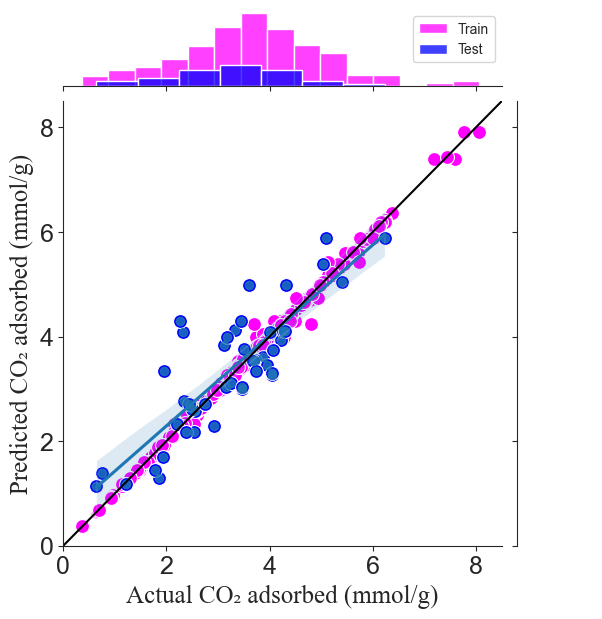

In [41]:
# Fitting optimized new one DT Regression to the entire data

# Say, "the default sans-serif font is COMIC SANS"
import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
label_size = 18
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 


# Then, "ALWAYS use sans-serif fonts"
#matplotlib.rcParams['font.family'] = "sans-serif"

from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(criterion='squared_error', splitter='best', max_depth=None, 
                              min_samples_split=3, min_samples_leaf=1, 
                              min_weight_fraction_leaf=0.0, max_features=None, random_state=None)

model.fit(x_train_std, y_train)

#Measure the R2 for training and test set
model_score = model.score(x_train_std,y_train)
print("The training R2 is: %.3f" % model.score(x_train_std, y_train))
print("The test R2 is: %.3f "% model.score(x_test_std, y_test))

from sklearn.metrics import mean_squared_error
from math import sqrt

y_predicted = model.predict(x_test_std)
y_predictedtrain = model.predict(x_train_std)
# The mean squared error & Variance
print("MSE-test: %.3f"% mean_squared_error(y_test, y_predicted))
print("RMSE-test: %.3f"% sqrt(mean_squared_error(y_test, y_predicted)))
print("MSE-train: %.3f"% mean_squared_error(y_train, y_predictedtrain))
print("RMSE-train: %.3f"% sqrt(mean_squared_error(y_train, y_predictedtrain)))
print("MAPE: %.3f"% mean_absolute_percentage_error(y_true=y_test, y_pred=y_predicted))

#k-cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model, X = x_train_std, y= y_train, cv=5)
print("The mean training accuracy is: %.3f"% accuracies.mean())

#Plotting the joint plot of  actual v/s predicted
pp_tr = model.predict(x_train_std)

from sklearn.metrics import mean_squared_error, r2_score
g = sns.JointGrid()
sns.set_style("ticks")
sns.scatterplot(x=y_train, y=pp_tr, s=100, color='magenta', ax=g.ax_joint)
sns.scatterplot(x=y_test, y=y_predicted, s=100, color='blue', ax=g.ax_joint)
sns.regplot(x=y_test, y=y_predicted,  ax=g.ax_joint)
sns.set_style("ticks")
plt.ylim(0, 8.5)
plt.xlim(0, 8.5)
g.ax_joint.set_xlim(0, 8.5)

g.set_axis_labels("Actual CO\u2082 adsorbed (mmol/g)", "Predicted CO\u2082 adsorbed (mmol/g)", 
                  fontsize =18, fontname = 'Times New Roman')
sns.histplot(x=y_train,ax=g.ax_marg_x, color ='magenta')
sns.histplot(x=y_test, ax=g.ax_marg_x, color ='blue')
g.ax_marg_x.legend(["Train", "Test"])

#line of equality
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-k')

plt.show()

In [42]:
model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}